In [3]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone

In [4]:
start_day_to_analyze = '2020-04-07'
end_day_to_analyze = '2020-04-08'

In [5]:
base_url = "https://api.alpaca.markets"
api_key_id = "AKVKN4TLUUS5MZO5KYLM"
api_secret = "nkK2UmvE1kTFFw1ZlaqDmwCyiuCu7OOeB5y2La/X"

In [6]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [7]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [9]:
api.get_asset('MGY')

Asset({   'class': 'us_equity',
    'easy_to_borrow': True,
    'exchange': 'NYSE',
    'id': '9767ecdd-7500-45a5-af5c-5f196547dfc7',
    'marginable': True,
    'name': 'Magnolia Oil & Gas Corporation Class A Common Stock',
    'shortable': True,
    'status': 'active',
    'symbol': 'MGY',
    'tradable': True})

In [6]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [8]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,1291,195,AM,buy,336,2.68,"{'rsi': 67.75879158548005, 'macd': [-0.0087861...",2020-04-07T14:38:28.71054007Z,2020-04-07 14:38:28.875814,2.50,3.22
1,1317,195,AM,sell,336,2.61,"{'rsi': 47.73507296486781, 'reasons': 'below c...",2020-04-07T14:52:08.445251378Z,2020-04-07 14:52:09.460889,2.50,3.22
2,1322,195,AM,buy,441,2.67,"{'rsi': 58.46766528738534, 'macd': [-0.0001629...",2020-04-07T15:00:42.285136266Z,2020-04-07 15:00:43.037484,2.54,3.08
3,1325,195,AM,sell,147,2.73,"{'rsi': 64.86918388164288, 'reasons': 'scale-o...",2020-04-07T15:07:07.704348937Z,2020-04-07 15:07:08.277726,2.54,3.08
4,1330,195,AM,sell,294,2.62,"{'rsi': 42.304981354223834, 'reasons': 'below ...",2020-04-07T15:17:10.651906527Z,2020-04-07 15:17:10.812689,2.54,3.08
...,...,...,...,...,...,...,...,...,...,...,...
73,1319,195,WES,sell,159,4.95,"{'rsi': 43.405309379933605, 'reasons': 'below ...",2020-04-07T14:54:26.744750728Z,2020-04-07 14:54:27.623322,4.69,6.21
74,1281,195,WPX,buy,183,4.50,"{'rsi': 63.832496881263864, 'macd': [0.0053421...",2020-04-07T14:35:48.887376082Z,2020-04-07 14:35:56.245291,4.17,5.49
75,1309,195,WPX,sell,183,4.33,"{'rsi': 41.159236161392954, 'reasons': 'below ...",2020-04-07T14:49:18.046395872Z,2020-04-07 14:49:25.541306,4.17,5.49
76,1290,195,WRI,buy,104,15.14,"{'rsi': 63.9067269501377, 'macd': [0.033034427...",2020-04-07T14:38:08.749516311Z,2020-04-07 14:38:11.272129,14.56,16.88


In [9]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [10]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [11]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
20,195,momentum_long,PAPER,v0.1-207-g4227d6e,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-07 13:55:42.609711,NaT,None


,symbol,count,revenue
8,LC,2,-96.24
11,HT,2,-64.26
7,IMAX,2,-63.80
33,SRET,2,-60.40
31,WRI,2,-55.12
10,OFG,2,-52.92
16,CMO,2,-52.39
29,PDCE,2,-48.75
26,HOV,2,-44.20
35,DCP,2,-39.76


TOTAL REVENUE: -877.58 $


In [14]:

minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=7)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df

In [15]:
lbound = (datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)) + timedelta(hours=9, minutes=30)
ubound = lbound + timedelta(minutes=15)

print(lbound, ubound)

2020-04-09 09:30:00 2020-04-09 09:45:00


In [16]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.01 <= float(item - prev) / prev <= 0.01:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    minute_history_index = minute_history["high"].index.get_loc(now, method='nearest')
    series = minute_history["high"][minute_history_index-200:minute_history_index].dropna().resample("5min").min()
    print(f'current_value={current_value} series = {series.values}')
    diff = np.diff(series.values)
    high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
    if len(high_index) > 0:
        local_maximas = sorted([series[i] for i in high_index if series[i] > current_value])
        print(local_maximas)
        clusters = dict(enumerate(grouper(local_maximas), 1))
        print(clusters)
        resistances = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                resistances.append(round(sum(cluster) / len(cluster), 2))
        resistances = sorted(resistances)
        print (f'resistances={resistances}')
        return resistances

    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    minute_history_index = minute_history["high"].index.get_loc(now, method='nearest')
    series = minute_history["high"][minute_history_index-200:minute_history_index].dropna().resample("5min").min()
    print(f'current_value={current_value} series = {series.values}')
    diff = np.diff(series.values)
    high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
    if len(high_index) > 0:
        local_maximas = sorted([series[i] for i in high_index if series[i] <= current_value])
        print(local_maximas)
        clusters = dict(enumerate(grouper(local_maximas), 1))
        print(clusters)
        supports = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                supports.append(round(sum(cluster) / len(cluster), 2))
        supports = sorted(supports)
        print (f'supports={supports}')
        return supports
    
    return None

current_value=2.68 series = [2.66   2.66   2.67   2.67   2.675  2.65   2.625  2.61   2.635  2.6
 2.61   2.615  2.605  2.6    2.59   2.59   2.565  2.56   2.63   2.605
 2.605  2.605  2.605  2.6    2.595  2.66   2.645  2.645  2.625  2.6058
 2.5999 2.595  2.615  2.545  2.51   2.505  2.5075 2.495  2.5    2.49
 2.485 ]
[]
{}
resistances=[]
current_value=2.68 series = [2.66   2.66   2.67   2.67   2.675  2.65   2.625  2.61   2.635  2.6
 2.61   2.615  2.605  2.6    2.59   2.59   2.565  2.56   2.63   2.605
 2.605  2.605  2.605  2.6    2.595  2.66   2.645  2.645  2.625  2.6058
 2.5999 2.595  2.615  2.545  2.51   2.505  2.5075 2.495  2.5    2.49
 2.485 ]
[2.5, 2.5075, 2.59, 2.605, 2.605, 2.605, 2.615, 2.615, 2.63, 2.635, 2.645, 2.66, 2.67, 2.675]
{1: [2.5, 2.5075], 2: [2.59, 2.605, 2.605, 2.605, 2.615, 2.615, 2.63, 2.635, 2.645, 2.66, 2.67, 2.675]}
supports=[2.5, 2.63]
current_value=2.67 series = [2.65   2.625  2.61   2.635  2.6    2.61   2.615  2.605  2.6    2.59
 2.59   2.565  2.56   2.63   2.60

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-900.48,-900.48,buy,2020-04-07 14:38:28.875814,2.68,"[2.5, 2.63]",[],336,"{'rsi': 67.75879158548005, 'macd': [-0.008786192523323688, -0.0014196877275458597, 0.004367969166326091, 0.009251541158205256, 0.014168852078814798], 'sell_macd': [-0.005093251414293842, -0.00025484053899571535, 0.003518659370834065, 0.006673092295755634, 0.009823649220424446], 'slow macd': [0.0028827440659728865, 0.003921699726490591, 0.00487129995677682, 0.0058171395929469405, 0.006917942649506514], 'macd_signal': [-0.018483178708614403, -0.015070480512400694, -0.011182790576655336, -0.007095924229683218, -0.0028429689679836147], 'sell_macd_signal': [-0.011919770618875534, -0.00958678460289957, -0.0069656958081528424, -0.0042379381873711465, -0.0014256207058120276]}",3.22,2.50
1,-23.52,876.96,sell,2020-04-07 14:52:09.460889,2.61,None,None,336,"{'rsi': 47.73507296486781, 'reasons': 'below cost & macd negative', 'movement': -0.02611940298507473, 'sell_macd': [0.009749395109780234, 0.0068445590749828256, 0.0031934588001409914, 0.0005667123677945973, -0.00018876163621284192], 'sell_macd_signal': [0.00874470984515105, 0.008364679691117404, 0.007330435512922122, 0.005977690883896617, 0.004744400379874726]}",3.22,2.50
2,-1200.99,-1177.47,buy,2020-04-07 15:00:43.037484,2.67,"[2.49, 2.62]",[],441,"{'rsi': 58.46766528738534, 'macd': [-0.00016290169377031205, 0.00075626350681679, 0.004658671985831919, 0.006865303449609339, 0.009712489884766917], 'sell_macd': [-0.00040829656765994926, 0.00020878928531198326, 0.0027648459332731967, 0.004201190776706998, 0.006045080384879942], 'slow macd': [0.006112505520039058, 0.006132409448731391, 0.006780657870213425, 0.007206286413336205, 0.007826256877978999], 'macd_signal': [0.0010229382229822062, 0.0009696032797491229, 0.0017074170209656822, 0.0027389943066944136, 0.004133693422308914], 'sell_macd_signal': [0.00036168036497953777, 0.0003311021490460269, 0.0008178509058914608, 0.001494518880054568, 0.002404631181019643]}",3.08,2.54
3,-799.68,401.31,sell,2020-04-07 15:07:08.277726,2.73,None,None,147,"{'rsi': 64.86918388164288, 'reasons': 'scale-out', 'movement': 0.020560747663551465, 'sell_macd': [0.005867321833395334, 0.008179704276147781, 0.009615590539641339, 0.010609585153536827, 0.013324261668864246], 'sell_macd_signal': [0.003327670836333811, 0.004298077524296605, 0.005361580127365552, 0.006411181132599806, 0.007793797239852694]}",3.08,2.54
4,-29.40,770.28,sell,2020-04-07 15:17:10.812689,2.62,None,None,294,"{'rsi': 42.304981354223834, 'reasons': 'below cost & macd negative', 'movement': -0.03846153846153846, 'sell_macd': [0.007389729553548996, 0.006180593976079507, 0.0043789221757650765, 0.0013597113940164718, -0.0007508387137620254], 'sell_macd_signal': [0.010133956233445414, 0.009343283781972233, 0.008350411460730801, 0.006952271447387935, 0.005411649415157943]}",3.08,2.54


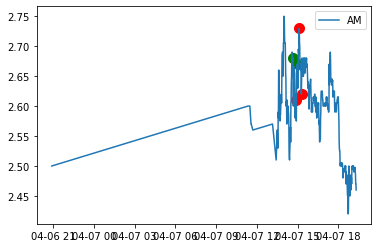

current_value=15.11 series = [14.9    15.05   14.98   15.1    15.24   15.47   15.4    15.55   15.68
 15.795  15.965  15.875  15.73   15.715  15.79   15.91   15.98   15.969
 16.04   16.04   16.04   16.04   16.1245 16.02   15.96   15.95   15.94
 16.     16.135  16.06   15.91   15.985  16.01   15.98   16.02   16.
 16.01   15.91   15.91   15.68   15.72   15.45   15.4    15.57   15.51
 15.44   15.39   15.45   15.38   15.34   15.46  ]
[15.45, 15.47, 15.57, 15.72, 15.91, 15.965, 15.98, 16.01, 16.01, 16.02, 16.04, 16.04, 16.04, 16.1245, 16.135]
{1: [15.45, 15.47, 15.57, 15.72], 2: [15.91, 15.965, 15.98, 16.01, 16.01, 16.02, 16.04, 16.04, 16.04, 16.1245, 16.135]}
resistances=[15.55, 16.02]
current_value=15.11 series = [14.9    15.05   14.98   15.1    15.24   15.47   15.4    15.55   15.68
 15.795  15.965  15.875  15.73   15.715  15.79   15.91   15.98   15.969
 16.04   16.04   16.04   16.04   16.1245 16.02   15.96   15.95   15.94
 16.     16.135  16.06   15.91   15.985  16.01   15.98   16.02   16

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2417.60,-2417.60,buy,2020-04-07 15:02:00.981289,15.11,[],"[15.55, 16.02]",160,"{'rsi': 62.08186559024682, 'macd': [0.006917548323473355, 0.005404170859348412, 0.0025614486768077427, 0.01306858715286019, 0.028331233113839005], 'sell_macd': [0.00040981997964628647, -0.0002864319476021393, -0.0018642070604268923, 0.005242256579716553, 0.015387004135934745], 'slow macd': [0.077269856248666, 0.07528333717624314, 0.07301539885783015, 0.07337102154231623, 0.07502028332193866], 'macd_signal': [0.006015622891636997, 0.00589333248517928, 0.005226955723504972, 0.006795282009376015, 0.011102472230268614], 'sell_macd_signal': [-0.0016572268391033824, -0.0013830678608031338, -0.0014792957007278855, -0.00013498524463899765, 0.002969412631475751]}",16.25,14.77
1,-1596.63,820.97,sell,2020-04-07 15:16:21.815555,15.49,None,None,53,"{'rsi': 71.07539255168741, 'reasons': 'scale-out', 'movement': 0.02179656538969617, 'sell_macd': [0.02602445859945135, 0.03535730744282617, 0.046845796055286826, 0.053631036583761116, 0.06705289885810828], 'sell_macd_signal': [0.014426666507719036, 0.01861279469474046, 0.024259394966849736, 0.030133723290232013, 0.037517558403807265]}",16.25,14.77
2,98.25,1694.88,sell,2020-04-07 15:36:16.105357,15.84,None,None,107,"{'rsi': 78.24644494348793, 'reasons': 'rsi max', 'movement': 0.006337135614702245, 'sell_macd': [0.10605386212419177, 0.11297693644613105, 0.11768352765223966, 0.11982264381735774, 0.12434893376657641], 'sell_macd_signal': [0.08465688274449257, 0.09032089348482027, 0.09579342031830415, 0.10059926501811486, 0.10534919876780717]}",16.25,14.77


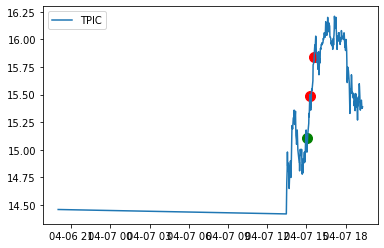

current_value=4.61 series = [4.75   4.8348 4.7    4.6768 4.73   4.705  4.8    4.79   4.8    4.82
 4.84   4.86   4.9    5.1022 5.025  4.98   5.0803 5.01   5.0175 5.0139
 5.09   5.105  5.07   5.08   5.1    5.124  5.07   5.07   5.055  5.02
 4.97   4.95   4.945  4.92   4.9    4.841  4.8848 4.8699 4.82   4.76
 4.73   4.67  ]
[4.73, 4.8, 4.8348, 4.8848, 5.0175, 5.07, 5.0803, 5.1022, 5.105, 5.124]
{1: [4.73], 2: [4.8, 4.8348], 3: [4.8848], 4: [5.0175], 5: [5.07, 5.0803, 5.1022, 5.105, 5.124]}
resistances=[4.82, 5.1]
current_value=4.61 series = [4.75   4.8348 4.7    4.6768 4.73   4.705  4.8    4.79   4.8    4.82
 4.84   4.86   4.9    5.1022 5.025  4.98   5.0803 5.01   5.0175 5.0139
 5.09   5.105  5.07   5.08   5.1    5.124  5.07   5.07   5.055  5.02
 4.97   4.95   4.945  4.92   4.9    4.841  4.8848 4.8699 4.82   4.76
 4.73   4.67  ]
[]
{}
supports=[]
CEQP analysis for run 195 with profit 24.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-769.87,-769.87,buy,2020-04-07 14:40:22.545503,4.61,[],"[4.82, 5.1]",167,"{'rsi': 64.51083957721995, 'macd': [-0.02144031538689184, -0.013186994199106294, -0.00854878535740422, -0.004434533012966035, 0.010805232020573818], 'sell_macd': [-0.013795219006778048, -0.008277251812655706, -0.005158352027461177, -0.002411698272407392, 0.007552079955847724], 'slow macd': [0.006317481096509425, 0.007024465905685062, 0.007267038549543692, 0.007555359820763385, 0.010207581254507048], 'macd_signal': [-0.026340374752291913, -0.02370969864165479, -0.020677515984804676, -0.017428919390436948, -0.011782089108234795], 'sell_macd_signal': [-0.017877027584339282, -0.015957072430002568, -0.013797328349494289, -0.011520202334076909, -0.007705745876091982]}",5.73,4.29
1,-503.12,266.75,sell,2020-04-07 15:07:43.219524,4.85,None,None,55,"{'rsi': 74.33897087997778, 'reasons': 'scale-out', 'movement': 0.021052631578947295, 'sell_macd': [0.007911458734239929, 0.01565378993022737, 0.02200295982411138, 0.029256820003448425, 0.03972921988340605], 'sell_macd_signal': [0.005803700071633191, 0.007773718043352027, 0.010619566399503897, 0.014347017120292804, 0.019423457672915454]}",5.73,4.29
2,24.40,527.52,sell,2020-04-07 15:36:59.316901,4.71,None,None,112,"{'rsi': 44.7534461175083, 'reasons': 'below cost & macd negative', 'movement': -0.036329896907216434, 'sell_macd': [0.008323189812046827, 0.006917526030873589, 0.004693404564623194, 0.0018604085576141571, -0.00121284039015368], 'sell_macd_signal': [0.013538042086037608, 0.012213938875004804, 0.010709832012928482, 0.008939947321865618, 0.0069093897794617574]}",5.73,4.29


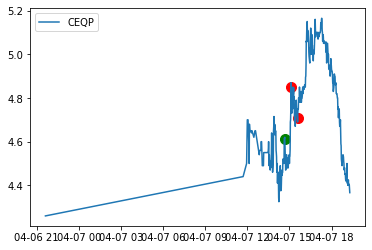

current_value=17.01 series = [17.3   17.25  17.225 17.26  17.265 17.26  17.27  17.3   17.24  17.24
 17.23  17.08  17.03  17.12  17.125 17.035 17.02  17.04  16.995 16.985
 16.89  16.98  16.98  16.945 16.84  16.785 16.76  16.755 16.675 16.595
 16.76  16.6   16.575 16.72  16.63  16.545 16.51  16.52  16.45  16.31 ]
[17.04, 17.125, 17.24, 17.265, 17.3]
{1: [17.04, 17.125, 17.24, 17.265, 17.3]}
resistances=[17.19]
current_value=17.01 series = [17.3   17.25  17.225 17.26  17.265 17.26  17.27  17.3   17.24  17.24
 17.23  17.08  17.03  17.12  17.125 17.035 17.02  17.04  16.995 16.985
 16.89  16.98  16.98  16.945 16.84  16.785 16.76  16.755 16.675 16.595
 16.76  16.6   16.575 16.72  16.63  16.545 16.51  16.52  16.45  16.31 ]
[16.52, 16.72, 16.76, 16.98, 16.98]
{1: [16.52], 2: [16.72, 16.76], 3: [16.98, 16.98]}
supports=[16.74, 16.98]
SLB analysis for run 195 with profit 121.58


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4218.48,-4218.48,buy,2020-04-07 14:59:30.723655,17.01,"[16.74, 16.98]",[17.19],248,"{'rsi': 59.42813253071252, 'macd': [-0.01890108509616084, -0.01792356135344164, -0.010172811283180039, -0.0027877756294643063, 0.007018594476775775], 'sell_macd': [-0.01296990606899584, -0.012211755844365513, -0.007046810788235547, -0.0021514404745204274, 0.004288477178693739], 'slow macd': [0.06742945933187272, 0.0650179567316016, 0.06405476628372497, 0.06330605765289476, 0.06331565269881523], 'macd_signal': [-0.0028579002382596126, -0.005871032461296019, -0.006731388225672823, -0.00594266570643112, -0.003350413669789741], 'sell_macd_signal': [-0.002734502257086915, -0.004629952974542635, -0.005113324537281217, -0.004520947724729059, -0.0027590627440444992]}",17.81,16.85
1,-2788.40,1430.08,sell,2020-04-07 15:14:51.795656,17.44,None,None,82,"{'rsi': 74.88828377780675, 'reasons': 'scale-out', 'movement': 0.020479812755997744, 'sell_macd': [0.04045931191543062, 0.043759976568054526, 0.048101274004281436, 0.05449577494154667, 0.06136816820511015], 'sell_macd_signal': [0.027532791949103935, 0.030778228872894053, 0.03424283789917153, 0.03829342530764655, 0.04290837388713927]}",17.81,16.85
2,121.58,2909.98,sell,2020-04-07 15:15:59.739055,17.53,None,None,166,"{'rsi': 78.30055819634607, 'reasons': 'rsi max', 'movement': 0.005160550458715588, 'sell_macd': [0.043759976568054526, 0.048101274004281436, 0.05449577494154667, 0.06084868768562757, 0.07020357180198289], 'sell_macd_signal': [0.030778228872894053, 0.03424283789917153, 0.03829342530764655, 0.042804477783242756, 0.04828429658699078]}",17.81,16.85


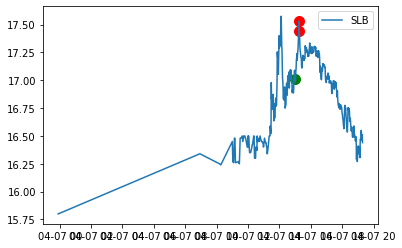

current_value=9.63 series = [9.05      nan    nan ... 9.89   9.8536 9.87  ]
[9.6408, 9.7, 9.7209, 9.82, 9.8837, 9.89, 9.8995, 9.9, 9.95]
{1: [9.6408, 9.7, 9.7209], 2: [9.82, 9.8837, 9.89, 9.8995, 9.9, 9.95]}
resistances=[9.69, 9.89]
current_value=9.63 series = [9.05      nan    nan ... 9.89   9.8536 9.87  ]
[9.13, 9.165, 9.17, 9.1854, 9.196, 9.215, 9.22, 9.32, 9.3658, 9.58, 9.5973]
{1: [9.13, 9.165, 9.17, 9.1854, 9.196, 9.215, 9.22], 2: [9.32, 9.3658], 3: [9.58, 9.5973]}
supports=[9.18, 9.34, 9.59]
FEN analysis for run 195 with profit 34.58


<ipython-input-16-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-16-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-16-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-16-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2378.61,-2378.61,buy,2020-04-07 14:09:40.343302,9.63,"[9.18, 9.34, 9.59]","[9.69, 9.89]",247,"{'rsi': 71.63015020481139, 'macd': [0.09617766434143604, 0.10981822635394956, 0.11360592335687159, 0.11767200022973867, 0.12230870432979302], 'sell_macd': [0.05996167259618268, 0.06857333915013442, 0.07071524374866733, 0.07302432208845033, 0.0756934179105091], 'slow macd': [0.05107177917805039, 0.05595232540532713, 0.05922074906280095, 0.06261289613980736, 0.06619341546793045], 'macd_signal': [0.05870803292897585, 0.06893007161397059, 0.07786524196255079, 0.08582659361598836, 0.09312301575874929], 'sell_macd_signal': [0.03583338398977348, 0.04238137502184567, 0.04804814876721, 0.05304338343145807, 0.05757339032726828]}",10.37,9.39
1,34.58,2413.19,sell,2020-04-07 15:54:31.531448,9.77,None,None,247,"{'rsi': 64.87945026289692, 'reasons': 'bail', 'movement': 0.020238713025428158, 'sell_macd': [0.028972162296563297, 0.0334000862297259, 0.0348322336292064, 0.036560761036215084, 0.03847181146977796], 'sell_macd_signal': [0.03370475402502419, 0.03364382046596453, 0.0338815030986129, 0.03441735468613334, 0.03522824604286227]}",10.37,9.39


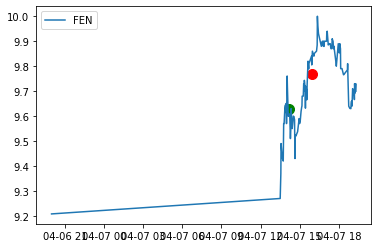

current_value=2.9 series = [2.97   2.98   2.98   2.95   2.96   2.97   2.97   2.985  2.97   2.96
 2.94   2.95   2.95   2.98   2.99   2.96   2.96   2.965  2.96   2.96
 2.97   2.96   2.96   2.96   2.96   2.96   2.95   2.91   2.895  2.88
 2.86   2.84   2.85   2.83   2.825  2.81   2.77   2.8    2.745  2.7386
 2.78  ]
[2.95, 2.96, 2.96, 2.96, 2.96, 2.965, 2.97, 2.97, 2.98, 2.98, 2.985, 2.99]
{1: [2.95, 2.96, 2.96, 2.96, 2.96, 2.965, 2.97, 2.97, 2.98, 2.98, 2.985, 2.99]}
resistances=[2.97]
current_value=2.9 series = [2.97   2.98   2.98   2.95   2.96   2.97   2.97   2.985  2.97   2.96
 2.94   2.95   2.95   2.98   2.99   2.96   2.96   2.965  2.96   2.96
 2.97   2.96   2.96   2.96   2.96   2.96   2.95   2.91   2.895  2.88
 2.86   2.84   2.85   2.83   2.825  2.81   2.77   2.8    2.745  2.7386
 2.78  ]
[2.8, 2.85]
{1: [2.8], 2: [2.85]}
supports=[]
MTDR analysis for run 195 with profit -25.15


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1458.70,-1458.70,buy,2020-04-07 14:29:21.052396,2.90,[],[2.97],503,"{'rsi': 58.04607460231814, 'macd': [-0.003565727612748759, -0.004972272871173633, -0.002826719750325335, 0.0028750864811124544, 0.006511828269490927], 'sell_macd': [-0.002963841397344069, -0.0037987201030018625, -0.002322018833345929, 0.0014562161668192353, 0.0038619029699762386], 'slow macd': [0.01654790286992691, 0.015711644868069197, 0.015556876278806087, 0.016189283304392177, 0.016585289474986276], 'macd_signal': [-0.005000009678623123, -0.004994462317133225, -0.004560913803771647, -0.003073713746794827, -0.0011566053435376764], 'sell_macd_signal': [-0.004371696780462325, -0.004257101444970233, -0.0038700849226453718, -0.00280482470475245, -0.0014714791698067122]}",3.26,2.78
1,-25.15,1433.55,sell,2020-04-07 14:50:19.255550,2.85,None,None,503,"{'rsi': 41.22135744478629, 'reasons': 'below cost & macd negative', 'movement': -0.01551724137931032, 'sell_macd': [0.0072476191031949355, 0.0058356231563849725, 0.0036206182217748406, 0.0008086582958219957, -0.001392981364606527], 'sell_macd_signal': [0.009740561242815712, 0.008959573625529564, 0.00789178254477862, 0.006475157694987295, 0.00490152988306853]}",3.26,2.78


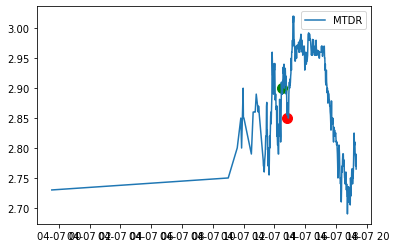

current_value=15.83 series = [15.215  15.04   15.0795 15.17   15.04   15.05   14.82   14.95   14.815
 14.86   15.06   15.04   14.96   14.77   14.86   14.84   14.83   14.96
 14.96   14.69   14.78   14.8    14.8034 14.81   14.83   14.76   14.74
 14.75   14.73   14.64   14.76   14.78   14.79   14.75   14.7199 14.64
 14.6345 14.68   14.65   14.7    14.65   14.61   14.55   14.47   14.42
 14.295 ]
[]
{}
resistances=[]
current_value=15.83 series = [15.215  15.04   15.0795 15.17   15.04   15.05   14.82   14.95   14.815
 14.86   15.06   15.04   14.96   14.77   14.86   14.84   14.83   14.96
 14.96   14.69   14.78   14.8    14.8034 14.81   14.83   14.76   14.74
 14.75   14.73   14.64   14.76   14.78   14.79   14.75   14.7199 14.64
 14.6345 14.68   14.65   14.7    14.65   14.61   14.55   14.47   14.42
 14.295 ]
[14.68, 14.7, 14.75, 14.79, 14.83, 14.86, 14.95, 14.96, 14.96, 15.05, 15.06, 15.17]
{1: [14.68, 14.7, 14.75, 14.79, 14.83, 14.86, 14.95, 14.96, 14.96, 15.05, 15.06, 15.17]}
supports=[14.9]


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-744.01,-744.01,buy,2020-04-07 14:03:37.459745,15.83,[14.9],[],47,"{'rsi': 66.89152050853563, 'macd': [0.11568882712169248, 0.1549190202207278, 0.19745072113625994, 0.24128666092892637, 0.2553314951148735], 'sell_macd': [0.07157055409279067, 0.09676648297650736, 0.12397413557451564, 0.15187653843563176, 0.16021767652954466], 'slow macd': [0.07375778285046408, 0.08384387305186358, 0.0957082145397532, 0.10902969271067597, 0.11759290842457126], 'macd_signal': [0.0906481954088548, 0.1035023603712294, 0.12229203252423551, 0.14609095820517368, 0.16793906558711363], 'sell_macd_signal': [0.056272040011105445, 0.06437092860418583, 0.07629156999825179, 0.09140856368572778, 0.10517038625449115]}",19.68,14.56
1,-33.84,710.17,sell,2020-04-07 14:22:48.289980,15.11,None,None,47,"{'rsi': 43.60082911381093, 'reasons': 'below cost & macd negative', 'movement': -0.05050505050505055, 'sell_macd': [0.023610847842276073, 0.01340774822462798, -0.003807754701131927, -0.012352201725084555, -0.023670573409656726], 'sell_macd_signal': [0.08162713124177812, 0.06798325463834809, 0.053625052770452084, 0.040429601871344756, 0.02760956681514446]}",19.68,14.56


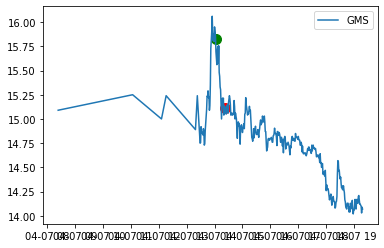

current_value=10.87 series = [10.005   9.91    9.875   9.95   10.07   10.1    10.13   10.17    9.98
 10.035  10.11   10.21   10.37   10.4    10.3681 10.34   10.38   10.42
 10.39   10.47   10.45   10.4    10.46   10.435  10.47   10.55   10.51
 10.57   10.53   10.44   10.395  10.37   10.3101 10.31   10.43   10.44
 10.39   10.44   10.42   10.45   10.46  ]
[]
{}
resistances=[]
current_value=10.87 series = [10.005   9.91    9.875   9.95   10.07   10.1    10.13   10.17    9.98
 10.035  10.11   10.21   10.37   10.4    10.3681 10.34   10.38   10.42
 10.39   10.47   10.45   10.4    10.46   10.435  10.47   10.55   10.51
 10.57   10.53   10.44   10.395  10.37   10.3101 10.31   10.43   10.44
 10.39   10.44   10.42   10.45   10.46  ]
[10.17, 10.4, 10.42, 10.44, 10.44, 10.46, 10.47, 10.55, 10.57]
{1: [10.17], 2: [10.4, 10.42, 10.44, 10.44, 10.46, 10.47, 10.55, 10.57]}
supports=[10.47]
IMAX analysis for run 195 with profit -63.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1195.7,-1195.7,buy,2020-04-07 14:02:31.365899,10.87,[10.47],[],110,"{'rsi': 62.92409964969629, 'macd': [0.09932440805800624, 0.10321583396827627, 0.10269526071884805, 0.10792962343546364, 0.1167516497982195], 'sell_macd': [0.056814741841332506, 0.05938334191214878, 0.05905519466977083, 0.0624689085761041, 0.06819298553459419], 'slow macd': [0.09697079628809924, 0.09904655469145318, 0.1003180996204236, 0.1026933705052997, 0.10590757475323365], 'macd_signal': [0.08405470701906415, 0.08788693240890658, 0.09084859807089488, 0.09426480314380863, 0.0987621724746908], 'sell_macd_signal': [0.04656229254613469, 0.04912650241933751, 0.051112240869424175, 0.05338357441076016, 0.056345456635526966]}",12.52,10.32
1,-63.8,1131.9,sell,2020-04-07 14:16:21.930581,10.29,None,None,110,"{'rsi': 35.66940972259715, 'reasons': 'stopped', 'movement': -0.051517939282428586, 'sell_macd': [0.04045388824627949, 0.026696093015404543, 0.01510955006907011, 0.0048458860840145945, -0.01100691554179356], 'sell_macd_signal': [0.05505907458040046, 0.04938647826740128, 0.042531092627735044, 0.03499405131899096, 0.025793857946834052]}",12.52,10.32


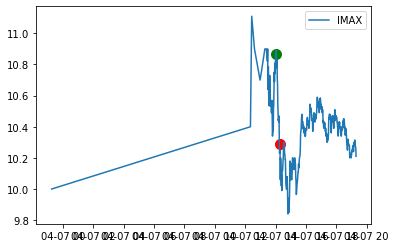

current_value=7.85 series = [7.89   7.9651 7.94   7.94   7.98   7.98   8.03   8.05   8.0346 8.01
 8.045  8.08   8.04   8.08   8.06   8.06   8.04   8.03   8.03   8.07
 8.06   8.05   8.05   8.03   8.02   8.04   8.02   8.03   8.03   8.
 7.91   7.9    7.87   7.91   7.86   7.82   7.85   7.81   7.8    7.86
 7.88   7.9    7.85   7.85  ]
[7.9, 7.91, 7.9651, 7.98, 8.03, 8.03, 8.04, 8.05, 8.05, 8.06, 8.07, 8.08, 8.08]
{1: [7.9, 7.91, 7.9651, 7.98, 8.03, 8.03, 8.04, 8.05, 8.05, 8.06, 8.07, 8.08, 8.08]}
resistances=[8.02]
current_value=7.85 series = [7.89   7.9651 7.94   7.94   7.98   7.98   8.03   8.05   8.0346 8.01
 8.045  8.08   8.04   8.08   8.06   8.06   8.04   8.03   8.03   8.07
 8.06   8.05   8.05   8.03   8.02   8.04   8.02   8.03   8.03   8.
 7.91   7.9    7.87   7.91   7.86   7.82   7.85   7.81   7.8    7.86
 7.88   7.9    7.85   7.85  ]
[7.85]
{1: [7.85]}
supports=[]
LC analysis for run 195 with profit -96.24


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9443.55,-9443.55,buy,2020-04-07 14:46:24.497843,7.85,[],[8.02],1203,"{'rsi': 57.03110500286835, 'macd': [0.004913599341762165, 0.007546934098587421, 0.008726362365631068, 0.010747551322824123, 0.013405205903840312], 'sell_macd': [0.002099901943768856, 0.003919747995380085, 0.004767423516176095, 0.0061452560841193105, 0.007918304109995056], 'slow macd': [0.033359318751389644, 0.03318637423121196, 0.03281424674706379, 0.03265929979463955, 0.032704413694396806], 'macd_signal': [-0.008054081350615354, -0.0049338782607747985, -0.002201830135493625, 0.0003880461561699246, 0.0029914781057040025], 'sell_macd_signal': [-0.007288623398981451, -0.005046949120109143, -0.0030840745928520956, -0.001238208457457814, 0.00059309405603276]}",8.01,7.81
1,-96.24,9347.31,sell,2020-04-07 14:49:17.282843,7.77,None,None,1203,"{'rsi': 44.875630284450075, 'reasons': 'stopped', 'movement': -0.011450381679389407, 'sell_macd': [0.0061452560841193105, 0.006879343071034327, 0.006842536267708255, 0.0046470694564444415, 0.001837003506675039], 'sell_macd_signal': [-0.001238208457457814, 0.00038530184824061425, 0.0016767487321341424, 0.0022708128769962023, 0.0021840510029319696]}",8.01,7.81


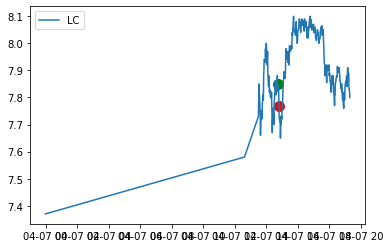

current_value=3.23 series = [3.11   3.05   3.07   3.12   3.17   3.22   3.22   3.24   3.3    3.37
 3.48   3.42   3.44   3.38   3.35   3.4    3.348  3.339  3.42   3.405
 3.4    3.45   3.47   3.5    3.51   3.415  3.42   3.46   3.41   3.38
 3.36   3.355  3.36   3.2531 3.21   3.27   3.25   3.23   3.26   3.29
 3.28  ]
[3.27, 3.29, 3.36, 3.4, 3.42, 3.44, 3.46, 3.48, 3.51]
{1: [3.27, 3.29], 2: [3.36], 3: [3.4, 3.42, 3.44, 3.46, 3.48, 3.51]}
resistances=[3.28, 3.45]
current_value=3.23 series = [3.11   3.05   3.07   3.12   3.17   3.22   3.22   3.24   3.3    3.37
 3.48   3.42   3.44   3.38   3.35   3.4    3.348  3.339  3.42   3.405
 3.4    3.45   3.47   3.5    3.51   3.415  3.42   3.46   3.41   3.38
 3.36   3.355  3.36   3.2531 3.21   3.27   3.25   3.23   3.26   3.29
 3.28  ]
[3.22]
{1: [3.22]}
supports=[]
IVR analysis for run 195 with profit -32.37


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-804.27,-804.27,buy,2020-04-07 14:36:14.749808,3.23,[],"[3.28, 3.45]",249,"{'rsi': 62.43857616600141, 'macd': [-0.002539550061089635, 0.0015717626332341084, 0.011755021722710257, 0.018993130448393902, 0.026242439216968005], 'sell_macd': [-0.005785920459680405, -0.002789725240008867, 0.004126657077137885, 0.009067647751834329, 0.01396883986521047], 'slow macd': [0.08108177961877505, 0.079804501458002, 0.07990116876956899, 0.07974076365514993, 0.0798255076683847], 'macd_signal': [0.007476751239306183, 0.006295753518091768, 0.007387607159015466, 0.009708711816891154, 0.013015457296906525], 'sell_macd_signal': [-0.0006647019476886281, -0.0010897066061526758, -4.643386949456339e-05, 0.0017763824547712152, 0.004214873936859066]}",3.97,3.0
1,-32.37,771.90,sell,2020-04-07 14:49:13.011991,3.10,None,None,249,"{'rsi': 43.141422971939015, 'reasons': 'below cost & macd negative', 'movement': -0.04160498396249692, 'sell_macd': [0.00815642164815511, 0.008123128074991826, 0.007243637913111556, 0.0026668450868010396, -0.0005445109478152688], 'sell_macd_signal': [0.0129106781820808, 0.011953168160663006, 0.011011262111152716, 0.009342378706282382, 0.007365000775462852]}",3.97,3.0


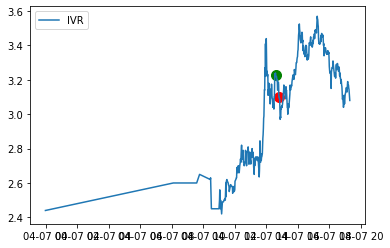

current_value=12.1 series = [11.345  11.65   11.835  11.94   11.91   11.6    11.51   11.36   11.28
 11.34   11.45   11.34   11.34   11.07   11.27   11.24   11.34   11.31
 11.34   11.29   11.36   11.46   11.47   11.51   11.46   11.4658 11.42
 11.48   11.49   11.5    11.505  11.53   11.68   11.75   11.9    11.89
 12.06   12.08   12.02   12.02   12.03   11.99   12.     11.97   11.94
 11.98   11.99   11.89   11.95   11.93   11.94   12.01   12.05  ]
[]
{}
resistances=[]
current_value=12.1 series = [11.345  11.65   11.835  11.94   11.91   11.6    11.51   11.36   11.28
 11.34   11.45   11.34   11.34   11.07   11.27   11.24   11.34   11.31
 11.34   11.29   11.36   11.46   11.47   11.51   11.46   11.4658 11.42
 11.48   11.49   11.5    11.505  11.53   11.68   11.75   11.9    11.89
 12.06   12.08   12.02   12.02   12.03   11.99   12.     11.97   11.94
 11.98   11.99   11.89   11.95   11.93   11.94   12.01   12.05  ]
[11.27, 11.34, 11.34, 11.34, 11.45, 11.4658, 11.51, 11.9, 11.94, 11.95, 11.99, 12

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-762.30,-762.30,buy,2020-04-07 14:07:31.706458,12.10,"[11.39, 11.98]",[],63,"{'rsi': 72.55139584574707, 'macd': [0.13029714452089358, 0.14139179232584276, 0.15286034211803035, 0.18602960087694598, 0.20590831243020524], 'sell_macd': [0.07704417036721622, 0.08410995960612766, 0.0913805751220842, 0.11274234597708599, 0.12532629279946406], 'slow macd': [0.10220263226728576, 0.1066619791590444, 0.11147377815196613, 0.12092042124277214, 0.12861855961421398], 'macd_signal': [0.11234306075418786, 0.11815280706851884, 0.12509431407842114, 0.1372813714381261, 0.15100675963654192], 'sell_macd_signal': [0.06591290081026305, 0.06955231256943598, 0.07391796507996562, 0.0816828412593897, 0.09041153156740457]}",14.99,11.15
1,-52.92,709.38,sell,2020-04-07 14:26:00.893002,11.26,None,None,63,"{'rsi': 38.239877856717, 'reasons': 'below cost & macd negative', 'movement': -0.06853839801816682, 'sell_macd': [0.05460296214447169, 0.03955908589320778, 0.02680335003646661, 0.009242992874895606, -0.00871628534028801], 'sell_macd_signal': [0.08882059123332006, 0.0789682901652976, 0.0685353021395314, 0.056676840286604246, 0.04359821516122579]}",14.99,11.15


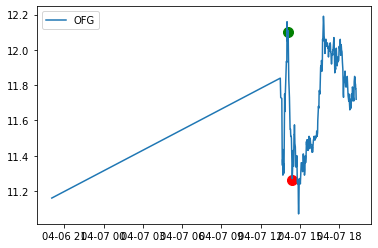

current_value=3.91 series = [3.73   3.77   3.85   3.835  3.82   3.86   3.85   3.89   3.86   3.85
 3.85   3.84   3.85   3.85   3.85   3.88   3.86   3.855  3.86   3.885
 3.925  3.975  3.975  4.0001 4.01   3.995  3.995  3.88   3.8679 3.93
 3.97   3.93   3.91   3.9    3.935  3.875  3.835  3.88   3.88   3.81
 3.845  3.82  ]
[3.935, 3.97, 3.975, 3.995, 4.01]
{1: [3.935, 3.97, 3.975, 3.995, 4.01]}
resistances=[3.98]
current_value=3.91 series = [3.73   3.77   3.85   3.835  3.82   3.86   3.85   3.89   3.86   3.85
 3.85   3.84   3.85   3.85   3.85   3.88   3.86   3.855  3.86   3.885
 3.925  3.975  3.975  4.0001 4.01   3.995  3.995  3.88   3.8679 3.93
 3.97   3.93   3.91   3.9    3.935  3.875  3.835  3.88   3.88   3.81
 3.845  3.82  ]
[3.845, 3.85, 3.85, 3.85, 3.85, 3.86, 3.88, 3.88, 3.88, 3.89]
{1: [3.845, 3.85, 3.85, 3.85, 3.85, 3.86, 3.88, 3.88, 3.88, 3.89]}
supports=[3.86]
HT analysis for run 195 with profit -64.26


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1477.98,-1477.98,buy,2020-04-07 14:32:51.465114,3.91,[3.86],[3.98],378,"{'rsi': 62.308299644913376, 'macd': [0.005948348840195017, 0.006802749287533327, 0.005799185543567731, 0.01013201525363927, 0.017000961433853323], 'sell_macd': [0.0004572416210240071, 0.0012218386875035847, 0.0007627995355723449, 0.0037718235790600296, 0.00840519525477701], 'slow macd': [0.049616514250640176, 0.048827686667734405, 0.04770397494644829, 0.0476334125432234, 0.04821202200344166], 'macd_signal': [0.013892261951593201, 0.012474359418781226, 0.011139324643738527, 0.010937862765718676, 0.012150482499345605], 'sell_macd_signal': [0.004839391641100176, 0.0041158810503808575, 0.003445264747419155, 0.00351057651374733, 0.004489500261953266]}",4.39,3.75
1,-64.26,1413.72,sell,2020-04-07 14:49:04.670005,3.74,None,None,378,"{'rsi': 40.3833807902908, 'reasons': 'stopped', 'movement': -0.043478260869565195, 'sell_macd': [0.010852126749443247, 0.010349546350118644, 0.008784554527915933, 0.00485359265960339, -0.0008699307788164745], 'sell_macd_signal': [0.010168814603214345, 0.010204960952595205, 0.00992087966765935, 0.008907422266048157, 0.006951951657075231]}",4.39,3.75


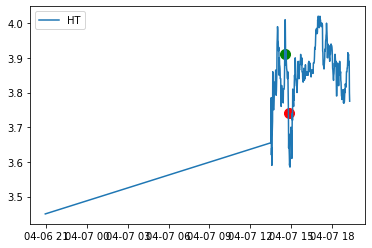

current_value=11.6 series = [11.2    11.09   11.12   11.15   11.22   11.42   11.3    11.28   11.31
 11.305  11.33   11.3    11.345  11.32   11.245  11.32   11.24   11.2
 11.24   11.22   11.24   11.28   11.1607 11.1216 11.125  11.065  11.0727
 11.12   11.13   11.061  11.06   11.     10.975  10.94   10.81   10.89
 10.86   10.86   11.04   10.91   10.89  ]
[]
{}
resistances=[]
current_value=11.6 series = [11.2    11.09   11.12   11.15   11.22   11.42   11.3    11.28   11.31
 11.305  11.33   11.3    11.345  11.32   11.245  11.32   11.24   11.2
 11.24   11.22   11.24   11.28   11.1607 11.1216 11.125  11.065  11.0727
 11.12   11.13   11.061  11.06   11.     10.975  10.94   10.81   10.89
 10.86   10.86   11.04   10.91   10.89  ]
[10.89, 11.04, 11.125, 11.13, 11.24, 11.28, 11.31, 11.32, 11.33, 11.345, 11.42]
{1: [10.89], 2: [11.04, 11.125, 11.13, 11.24, 11.28, 11.31, 11.32, 11.33, 11.345, 11.42]}
supports=[11.25]
HA analysis for run 195 with profit -31.03


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1241.20,-1241.20,buy,2020-04-07 14:36:09.129282,11.60,[11.25],[],107,"{'rsi': 61.966317163022424, 'macd': [0.002158598054398553, 0.018802612222085457, 0.03430088415150401, 0.04525479082951911, 0.05677531838831307], 'sell_macd': [-0.0040468689425861015, 0.007260937610809037, 0.01771817729383507, 0.025117089030038287, 0.03280562948643073], 'slow macd': [0.14538535003909558, 0.1450441296450986, 0.14503400383735432, 0.14463279012325359, 0.14472486372715565], 'macd_signal': [-0.006430532153226564, -0.001383903278164159, 0.005753054207769474, 0.013653401532119401, 0.022277784903358133], 'sell_macd_signal': [-0.012502002061201296, -0.008549414126799229, -0.0032958958426723695, 0.0023867011318697623, 0.008470486802781957]}",13.29,11.04
1,-31.03,1210.17,sell,2020-04-07 14:47:09.203488,11.31,None,None,107,"{'rsi': 44.79161430494769, 'reasons': 'below cost & macd negative', 'movement': -0.023553644221902453, 'sell_macd': [0.020836362644660156, 0.016220776657549507, 0.008257712555156616, 0.004781848156472535, -0.0003056026497283426], 'sell_macd_signal': [0.022346694418523237, 0.02112151086632849, 0.018548751204094115, 0.0157953705945698, 0.01257517594571017]}",13.29,11.04


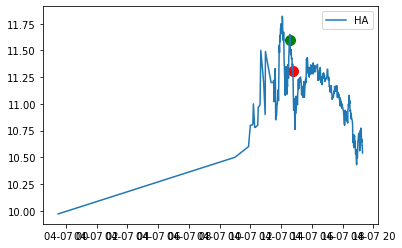

current_value=13.76 series = [13.61  13.63  13.625 13.63  13.62  13.6   13.76  13.81  13.88  13.875
 13.86  13.83  13.88  13.91  13.81  13.805 13.76  13.695 13.63  13.63
 13.62  13.66  13.65  13.62  13.61  13.61  13.57  13.575 13.58  13.59
 13.605 13.6   13.58  13.625 13.54  13.48  13.47  13.445 13.38  13.3
 13.3  ]
[13.88, 13.91]
{1: [13.88, 13.91]}
resistances=[13.9]
current_value=13.76 series = [13.61  13.63  13.625 13.63  13.62  13.6   13.76  13.81  13.88  13.875
 13.86  13.83  13.88  13.91  13.81  13.805 13.76  13.695 13.63  13.63
 13.62  13.66  13.65  13.62  13.61  13.61  13.57  13.575 13.58  13.59
 13.605 13.6   13.58  13.625 13.54  13.48  13.47  13.445 13.38  13.3
 13.3  ]
[13.605, 13.61, 13.625, 13.63, 13.63, 13.63, 13.66]
{1: [13.605, 13.61, 13.625, 13.63, 13.63, 13.63, 13.66]}
supports=[13.63]
TSU analysis for run 195 with profit -30.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2641.92,-2641.92,buy,2020-04-07 14:22:03.078036,13.76,[13.63],[13.9],192,"{'rsi': 75.04234164880171, 'macd': [0.05978249086450482, 0.0655264110252407, 0.06848217284889024, 0.07320840022811481, 0.07767244275909668], 'sell_macd': [0.03205640526598863, 0.03600895079978805, 0.03810172717937377, 0.041315556472824255, 0.044322234409632344], 'slow macd': [0.12191228641869323, 0.12220256776475225, 0.12211425393277509, 0.12247744180038289, 0.12293557275446787], 'macd_signal': [0.04877816312689755, 0.052127812706566176, 0.05539868473503099, 0.05896062783364776, 0.06270299081873754], 'sell_macd_signal': [0.023440423743459726, 0.02595412915472539, 0.028383648759655065, 0.030970030302288905, 0.03364047112375759]}",14.7,13.45
1,-30.72,2611.20,sell,2020-04-07 14:50:10.240435,13.60,None,None,192,"{'rsi': 37.17635087213643, 'reasons': 'below cost & macd negative', 'movement': -0.011627906976744196, 'sell_macd': [0.012517355860216739, 0.010762292825900133, 0.005618577567656047, -0.000540402861727074, -0.005332590172132612], 'sell_macd_signal': [0.017982951448224267, 0.01653881972375944, 0.014354771292538763, 0.011375736461685595, 0.008034071134921952]}",14.7,13.45


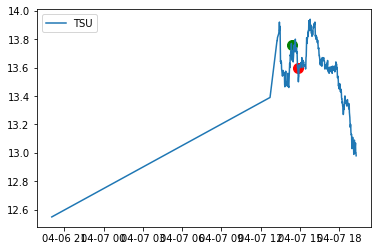

current_value=4.28 series = [4.28  4.28  4.26  4.29  4.27  4.29  4.27  4.25  4.24  4.25  4.27  4.26
 4.26  4.23  4.22  4.25  4.25  4.24  4.22  4.175 4.19  4.215 4.21  4.185
 4.15  4.165 4.175 4.17  4.175 4.16  4.145 4.135 4.135 4.085 4.04  4.06
 4.015 4.015 4.06  4.06  4.045 4.015 4.025 4.015 3.995]
[4.29, 4.29]
{1: [4.29, 4.29]}
resistances=[4.29]
current_value=4.28 series = [4.28  4.28  4.26  4.29  4.27  4.29  4.27  4.25  4.24  4.25  4.27  4.26
 4.26  4.23  4.22  4.25  4.25  4.24  4.22  4.175 4.19  4.215 4.21  4.185
 4.15  4.165 4.175 4.17  4.175 4.16  4.145 4.135 4.135 4.085 4.04  4.06
 4.015 4.015 4.06  4.06  4.045 4.015 4.025 4.015 3.995]
[4.025, 4.06, 4.06, 4.06, 4.135, 4.175, 4.175, 4.215, 4.25, 4.25, 4.26, 4.27, 4.28]
{1: [4.025, 4.06, 4.06, 4.06], 2: [4.135, 4.175, 4.175, 4.215, 4.25, 4.25, 4.26, 4.27, 4.28]}
supports=[4.05, 4.22]
MRC analysis for run 195 with profit -12.75


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1819.00,-1819.00,buy,2020-04-07 14:59:21.870783,4.28,"[4.05, 4.22]",[4.29],425,"{'rsi': 59.23358761719163, 'macd': [-0.006638671524957118, -0.0072625477927354964, -0.004876552870991979, 0.00023927281266367117, 0.005042392390312678], 'sell_macd': [-0.005058037741016541, -0.0053633118375522315, -0.0037133525382611055, -0.0003015225318225845, 0.002880442700879726], 'slow macd': [0.02121546337917568, 0.020302305710401924, 0.019989476834475717, 0.02030943798967666, 0.020731266404774296], 'macd_signal': [-0.00575520498152922, -0.006056673543770475, -0.005820649409214776, -0.004608664964839086, -0.0026784534938087334], 'sell_macd_signal': [-0.005006406459697459, -0.005077787535268413, -0.0048049005358669515, -0.0039042249350580783, -0.002547291407870517]}",4.7,4.14
1,-12.75,1806.25,sell,2020-04-07 15:26:46.347991,4.25,None,None,425,"{'rsi': 46.492898465482725, 'reasons': 'below cost & macd negative', 'movement': -0.00467289719626179, 'sell_macd': [0.005224199791336481, 0.0031523970939870694, 0.0025360261987277255, 0.0009838407452944509, -0.0002384315657604219], 'sell_macd_signal': [0.009826410867828409, 0.00849160811306014, 0.007300491730193657, 0.006037161533213816, 0.004782042913418968]}",4.7,4.14


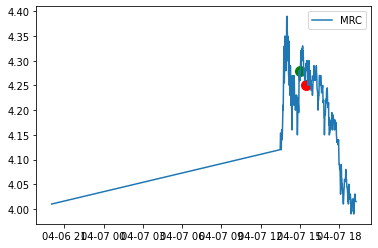

current_value=6.2 series = [6.345  6.23   6.23   6.24   6.26   6.31   6.31   6.29   6.285  6.32
 6.37   6.37   6.3695 6.31   6.32   6.38   6.38   6.402  6.46   6.45
 6.465  6.46   6.44   6.391  6.39   6.405  6.43   6.426  6.46   6.44
 6.44   6.385  6.385  6.325  6.255  6.33   6.275  6.285  6.35   6.3564
 6.33  ]
[6.31, 6.31, 6.33, 6.3564, 6.37, 6.37, 6.38, 6.385, 6.43, 6.44, 6.46, 6.46, 6.465]
{1: [6.31, 6.31, 6.33, 6.3564, 6.37, 6.37, 6.38, 6.385, 6.43, 6.44, 6.46, 6.46, 6.465]}
resistances=[6.39]
current_value=6.2 series = [6.345  6.23   6.23   6.24   6.26   6.31   6.31   6.29   6.285  6.32
 6.37   6.37   6.3695 6.31   6.32   6.38   6.38   6.402  6.46   6.45
 6.465  6.46   6.44   6.391  6.39   6.405  6.43   6.426  6.46   6.44
 6.44   6.385  6.385  6.325  6.255  6.33   6.275  6.285  6.35   6.3564
 6.33  ]
[]
{}
supports=[]
GT analysis for run 195 with profit -21.92


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1698.80,-1698.80,buy,2020-04-07 14:37:14.267713,6.20,[],[6.39],274,"{'rsi': 65.84775216451497, 'macd': [-0.007749392390056897, -0.0016367702843780307, 0.003968694559494779, 0.009910654826808418, 0.016048536462716534], 'sell_macd': [-0.005902272707006162, -0.001780125859918158, 0.001974535655474341, 0.005913563645967734, 0.009945097617183762], 'slow macd': [0.0332497666820073, 0.033310115620392544, 0.03347229972464749, 0.03388785207370493, 0.034535846694611294], 'macd_signal': [-0.013379591229672402, -0.011031027040613529, -0.008031082720591868, -0.00444273521111181, -0.0003444808763461409], 'sell_macd_signal': [-0.010497516980725726, -0.008754038756564213, -0.006608323874156502, -0.004103946370131654, -0.0012941375726685704]}",6.87,5.99
1,-21.92,1676.88,sell,2020-04-07 14:52:23.382073,6.12,None,None,274,"{'rsi': 39.74765602422328, 'reasons': 'below cost & macd negative', 'movement': -0.017713365539452547, 'sell_macd': [0.01225819745186385, 0.007540941922056454, 0.004546444860881849, 0.0005955842306040182, -0.0030102238479319254], 'sell_macd_signal': [0.016045635912893833, 0.014344697114726357, 0.012385046663957455, 0.010027154177286769, 0.00741967857224303]}",6.87,5.99


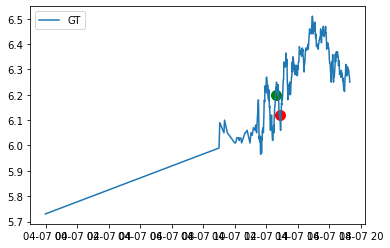

current_value=4.0 series = [3.92   3.89   3.87   3.905  3.95   3.99   4.03   4.03   4.02   4.05
 4.08   4.12   4.07   4.125  4.09   4.05   4.111  4.12   4.13   4.2
 4.19   4.25   4.27   4.27   4.28   4.275  4.21   4.175  4.175  4.12
 4.105  4.09   4.08   4.09   4.04   4.01   4.0766 4.02   4.01   4.06
 4.07  ]
[4.03, 4.03, 4.0766, 4.09, 4.12, 4.125, 4.175, 4.2, 4.27, 4.28]
{1: [4.03, 4.03], 2: [4.0766, 4.09, 4.12, 4.125], 3: [4.175, 4.2], 4: [4.27, 4.28]}
resistances=[4.03, 4.1, 4.19, 4.28]
current_value=4.0 series = [3.92   3.89   3.87   3.905  3.95   3.99   4.03   4.03   4.02   4.05
 4.08   4.12   4.07   4.125  4.09   4.05   4.111  4.12   4.13   4.2
 4.19   4.25   4.27   4.27   4.28   4.275  4.21   4.175  4.175  4.12
 4.105  4.09   4.08   4.09   4.04   4.01   4.0766 4.02   4.01   4.06
 4.07  ]
[]
{}
supports=[]
CMO analysis for run 195 with profit -52.39


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1612.00,-1612.00,buy,2020-04-07 14:32:07.529847,4.00,[],"[4.03, 4.1, 4.19, 4.28]",403,"{'rsi': 59.13065783221475, 'macd': [0.008280198590392196, 0.009187499304728952, 0.008198205000522929, 0.010520573223717467, 0.01541108310543704], 'sell_macd': [0.001261106708182691, 0.0020913905234345442, 0.0016722429700797292, 0.0034018391236982914, 0.006783318735301247], 'slow macd': [0.05844382061940534, 0.057552770528033204, 0.05632105627678996, 0.05573750620992968, 0.05575122123244647], 'macd_signal': [0.019471072339955257, 0.017414357732909995, 0.015571127186432582, 0.01456101639388956, 0.014731029736199056], 'sell_macd_signal': [0.0076938901195999845, 0.006573390200366897, 0.005593160754309464, 0.0051548964281872296, 0.005480580889610033]}",4.45,3.85
1,-52.39,1559.61,sell,2020-04-07 14:49:10.220699,3.87,None,None,403,"{'rsi': 37.6388914200707, 'reasons': 'below cost & macd negative', 'movement': -0.03500000000000003, 'sell_macd': [0.00964145983056408, 0.00845489178194958, 0.0069010089936529795, 0.00014602228856919197, -0.005379240368490468], 'sell_macd_signal': [0.012840751683760483, 0.011963579703398303, 0.010951065561449239, 0.00879005690687323, 0.005956197451800491]}",4.45,3.85


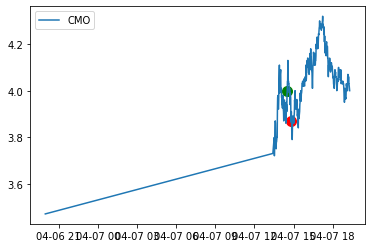

current_value=5.05 series = [5.45   5.47   5.435  5.52   5.505  5.52   5.46   5.4437 5.5299 5.48
 5.52   5.64   5.6325 5.57   5.4776 5.52   5.47   5.41   5.44   5.421
 5.35   5.2896 5.295  5.22   5.18   5.2    5.27   5.2397 5.21   5.17
 5.     4.95   4.9646 4.9252 4.89   4.9248 4.86   4.89   4.88   4.88
 4.87  ]
[5.27, 5.295, 5.44, 5.47, 5.52, 5.52, 5.52, 5.5299, 5.64]
{1: [5.27, 5.295], 2: [5.44, 5.47, 5.52, 5.52, 5.52, 5.5299], 3: [5.64]}
resistances=[5.28, 5.5]
current_value=5.05 series = [5.45   5.47   5.435  5.52   5.505  5.52   5.46   5.4437 5.5299 5.48
 5.52   5.64   5.6325 5.57   5.4776 5.52   5.47   5.41   5.44   5.421
 5.35   5.2896 5.295  5.22   5.18   5.2    5.27   5.2397 5.21   5.17
 5.     4.95   4.9646 4.9252 4.89   4.9248 4.86   4.89   4.88   4.88
 4.87  ]
[4.88, 4.89, 4.9248, 4.9646]
{1: [4.88, 4.89, 4.9248, 4.9646]}
supports=[4.91]
WES analysis for run 195 with profit -15.9


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-802.95,-802.95,buy,2020-04-07 14:36:58.090559,5.05,[4.91],"[5.28, 5.5]",159,"{'rsi': 63.62524580553076, 'macd': [0.015211211371592093, 0.024741691805382438, 0.030331194232934955, 0.03675794178463043, 0.042969690529865545], 'sell_macd': [0.006263517187621304, 0.012708879121333894, 0.016527227652520793, 0.020846366408607153, 0.024980158083368842], 'slow macd': [0.09606824871026287, 0.0960407754824919, 0.09554202338371898, 0.09541015746096448, 0.09545611343133409], 'macd_signal': [0.00628267813252231, 0.009974480867094335, 0.014045823540262459, 0.018588247189136053, 0.023464535857281952], 'sell_macd_signal': [-0.001245488666830563, 0.0015453848908023283, 0.0045417534431460216, 0.007802676036238248, 0.011238172445664368]}",6.21,4.69
1,-15.90,787.05,sell,2020-04-07 14:54:27.623322,4.95,None,None,159,"{'rsi': 43.405309379933605, 'reasons': 'below cost & macd negative', 'movement': -0.04423076923076931, 'sell_macd': [0.02131993190629089, 0.01623833473060632, 0.009454774142662714, 0.004581158435919441, -0.00031492079577599696], 'sell_macd_signal': [0.03421200007002724, 0.030617267002143057, 0.026384768430246987, 0.022024046431381478, 0.017556252985949983]}",6.21,4.69


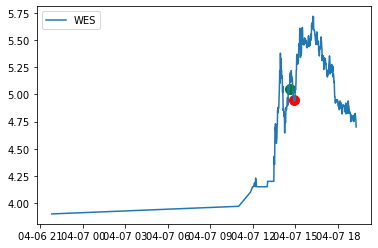

current_value=4.5 series = [4.47   4.36   4.37   4.395  4.39   4.42   4.43   4.42   4.425  4.42
 4.41   4.3801 4.39   4.35   4.33   4.35   4.29   4.28   4.29   4.2576
 4.225  4.2    4.19   4.16   4.13   4.105  4.105  4.13   4.14   4.12
 4.09   4.06   4.05   4.015  3.97   3.98   3.92   3.93   3.95   3.94
 3.95  ]
[]
{}
resistances=[]
current_value=4.5 series = [4.47   4.36   4.37   4.395  4.39   4.42   4.43   4.42   4.425  4.42
 4.41   4.3801 4.39   4.35   4.33   4.35   4.29   4.28   4.29   4.2576
 4.225  4.2    4.19   4.16   4.13   4.105  4.105  4.13   4.14   4.12
 4.09   4.06   4.05   4.015  3.97   3.98   3.92   3.93   3.95   3.94
 3.95  ]
[3.95, 3.98, 4.14, 4.29, 4.35, 4.39, 4.395, 4.425, 4.43]
{1: [3.95, 3.98], 2: [4.14], 3: [4.29], 4: [4.35, 4.39, 4.395, 4.425, 4.43]}
supports=[3.96, 4.4]
WPX analysis for run 195 with profit -31.11


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-823.50,-823.50,buy,2020-04-07 14:35:56.245291,4.50,"[3.96, 4.4]",[],183,"{'rsi': 63.832496881263864, 'macd': [0.00534212818160551, 0.008902522870006813, 0.01398371502906759, 0.01979964945535162, 0.027321539396680805], 'sell_macd': [0.0015926534417163296, 0.004054362030462499, 0.007478364021297423, 0.01134799720868429, 0.016293841287055244], 'slow macd': [0.05204136802921333, 0.05159571824869236, 0.05158299413115053, 0.051888627809283605, 0.05272657606284081], 'macd_signal': [-3.517597546955726e-05, 0.0017523637936257168, 0.0041986340407140915, 0.007318837123641597, 0.011319377578249438], 'sell_macd_signal': [-0.0029132193457033543, -0.0015197030704701834, 0.000279910347883338, 0.0024935277200435284, 0.005253590433445872]}",5.49,4.17
1,-31.11,792.39,sell,2020-04-07 14:49:25.541306,4.33,None,None,183,"{'rsi': 41.159236161392954, 'reasons': 'below cost & macd negative', 'movement': -0.03555555555555559, 'sell_macd': [0.01266171580464448, 0.011821857367356081, 0.00971519030755541, 0.004570836880339435, -1.6592243209601065e-05], 'sell_macd_signal': [0.014143009489411594, 0.013678779065000491, 0.012886061313511474, 0.011223016426877067, 0.008975094692859734]}",5.49,4.17


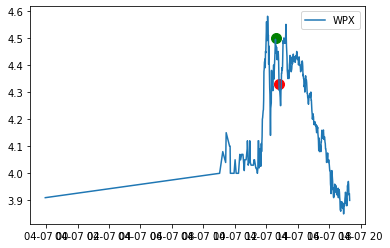

current_value=11.12 series = [10.745  10.4907 10.59   10.68   10.85   11.04   10.96   10.95   11.
 11.15   11.26   11.25   11.45   11.39   11.29   11.36   11.37   11.41
 11.46   11.41   11.48   11.4    11.35   11.2821 11.2    11.1699 11.1656
 11.26   11.18   11.1    11.0737 11.04   11.12   11.175  11.16   11.225
 11.17   11.18   11.29   11.29  ]
[11.175, 11.225, 11.26, 11.26, 11.29, 11.45, 11.46, 11.48]
{1: [11.175, 11.225, 11.26, 11.26, 11.29], 2: [11.45, 11.46, 11.48]}
resistances=[11.24, 11.46]
current_value=11.12 series = [10.745  10.4907 10.59   10.68   10.85   11.04   10.96   10.95   11.
 11.15   11.26   11.25   11.45   11.39   11.29   11.36   11.37   11.41
 11.46   11.41   11.48   11.4    11.35   11.2821 11.2    11.1699 11.1656
 11.26   11.18   11.1    11.0737 11.04   11.12   11.175  11.16   11.225
 11.17   11.18   11.29   11.29  ]
[11.04]
{1: [11.04]}
supports=[]
CNK analysis for run 195 with profit -11.05


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-722.80,-722.80,buy,2020-04-07 14:34:59.191559,11.12,[],"[11.24, 11.46]",65,"{'rsi': 59.23459928000885, 'macd': [-0.0752291978004287, -0.04897347757122006, -0.013086819527579507, 0.005605995971313504, 0.03135556941379214], 'sell_macd': [-0.05307791322050015, -0.035111351489408804, -0.0110450520692158, 0.0016175845188470817, 0.018736293749560318], 'slow macd': [0.14217994901380493, 0.14099938677769863, 0.1426465394156864, 0.14201459701758523, 0.1434451616532897], 'macd_signal': [-0.08920156385721915, -0.08115594660001933, -0.06754212118553136, -0.05291249775416239, -0.036058884320571485], 'sell_macd_signal': [-0.06704094336911501, -0.06065502499317377, -0.050733030408382174, -0.040262907422936325, -0.028463067188436997]}",14.13,10.45
1,-11.05,711.75,sell,2020-04-07 14:44:56.652358,10.95,None,None,65,"{'rsi': 43.04420220887684, 'reasons': 'below cost & macd negative', 'movement': -0.038504837291116915, 'sell_macd': [0.03713429083611963, 0.03085506476061539, 0.022112095549045918, 0.009630404013419636, -0.0011453348976324662], 'sell_macd_signal': [0.016442175009889943, 0.01932475296003503, 0.01988222147783721, 0.017831857984953695, 0.014036419408436463]}",14.13,10.45


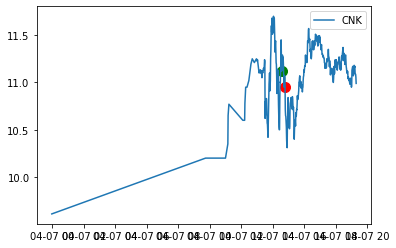

current_value=5.54 series = [5.555 5.51  5.46  5.46  5.5   5.5   5.52  5.55  5.52  5.49  5.5   5.505
 5.49  5.52  5.51  5.495 5.48  5.455 5.45  5.49  5.475 5.47  5.5   5.5
 5.47  5.45  5.43  5.455 5.515 5.495 5.48  5.48  5.46  5.47  5.41  5.36
 5.37  5.3   5.275 5.32  5.34  5.36 ]
[5.55]
{1: [5.55]}
resistances=[]
current_value=5.54 series = [5.555 5.51  5.46  5.46  5.5   5.5   5.52  5.55  5.52  5.49  5.5   5.505
 5.49  5.52  5.51  5.495 5.48  5.455 5.45  5.49  5.475 5.47  5.5   5.5
 5.47  5.45  5.43  5.455 5.515 5.495 5.48  5.48  5.46  5.47  5.41  5.36
 5.37  5.3   5.275 5.32  5.34  5.36 ]
[5.37, 5.47, 5.48, 5.49, 5.5, 5.5, 5.5, 5.505, 5.515, 5.52]
{1: [5.37], 2: [5.47, 5.48, 5.49, 5.5, 5.5, 5.5, 5.505, 5.515, 5.52]}
supports=[5.5]
RPAI analysis for run 195 with profit -38.19


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1113.54,-1113.54,buy,2020-04-07 14:36:32.074274,5.54,[5.5],[],201,"{'rsi': 70.12694155546856, 'macd': [-0.00498997021393599, -0.0008060096227957558, 0.004874369867388317, 0.01644874844383004, 0.02772270603569993], 'sell_macd': [-0.004617474871136729, -0.0017143719047005845, 0.0021284923795965582, 0.00977061399879453, 0.017157064429354385], 'slow macd': [0.046546523524850336, 0.04598176156537903, 0.04586842917233458, 0.047130223833236506, 0.04869554515246932], 'macd_signal': [-0.013709878036475557, -0.011129104353739597, -0.007928409509514015, -0.003052977918845203, 0.0031021588720638238], 'sell_macd_signal': [-0.011549329154246408, -0.009582337704337243, -0.007240171687550482, -0.003838014550281479, 0.00036100124564569444]}",6.44,5.24
1,-38.19,1075.35,sell,2020-04-07 14:51:05.081382,5.35,None,None,201,"{'rsi': 34.80602464668157, 'reasons': 'below cost & macd negative', 'movement': -0.0415162454873647, 'sell_macd': [0.026595738193007534, 0.022932348805712266, 0.01692279410384856, 0.009163104802346389, -0.00011929081963302224], 'sell_macd_signal': [0.027210805480270252, 0.026355114145358655, 0.024468650137056635, 0.021407541070114586, 0.017102174692165066]}",6.44,5.24


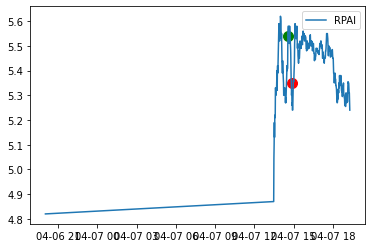

current_value=7.53 series = [7.49   7.37   7.355  7.47   7.485  7.52   7.49   7.43   7.46   7.47
 7.5    7.49   7.54   7.53   7.5    7.5    7.495  7.48   7.5    7.46
 7.38   7.335  7.285  7.22   7.2    7.19   7.22   7.29   7.275  7.2517
 7.255  7.245  7.26   7.22   7.165  7.19   7.15   7.15   7.11   7.09
 7.155 ]
[7.54]
{1: [7.54]}
resistances=[]
current_value=7.53 series = [7.49   7.37   7.355  7.47   7.485  7.52   7.49   7.43   7.46   7.47
 7.5    7.49   7.54   7.53   7.5    7.5    7.495  7.48   7.5    7.46
 7.38   7.335  7.285  7.22   7.2    7.19   7.22   7.29   7.275  7.2517
 7.255  7.245  7.26   7.22   7.165  7.19   7.15   7.15   7.11   7.09
 7.155 ]
[7.15, 7.19, 7.255, 7.26, 7.29, 7.5, 7.5, 7.5, 7.52]
{1: [7.15, 7.19, 7.255, 7.26, 7.29], 2: [7.5, 7.5, 7.5, 7.52]}
supports=[7.23, 7.5]
PE analysis for run 195 with profit -27.17


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1859.91,-1859.91,buy,2020-04-07 14:37:50.941858,7.53,"[7.23, 7.5]",[],247,"{'rsi': 58.043365408098126, 'macd': [-0.014976470922014151, -0.009813627007605241, -0.0016682236329810252, 0.003934792955490707, 0.009077500619329548], 'sell_macd': [-0.01005494864950407, -0.006544488242203883, -0.001126668597006386, 0.0025901605888236645, 0.00597223319351059], 'slow macd': [0.040470530982377184, 0.039838531727277804, 0.03999303616034755, 0.03991128588279924, 0.03993217651367864], 'macd_signal': [-0.02013165907911222, -0.018068052664810826, -0.014788086858444866, -0.011043510895657752, -0.007019308592660292], 'sell_macd_signal': [-0.014498511044156583, -0.012907706483766043, -0.010551498906414112, -0.007923167007366557, -0.0051440869671911275]}",8.27,7.29
1,-27.17,1832.74,sell,2020-04-07 14:48:17.865316,7.42,None,None,247,"{'rsi': 45.82419061206628, 'reasons': 'below cost & macd negative', 'movement': -0.011952191235059742, 'sell_macd': [0.004894675076873689, 0.00453851847255482, 0.003157896203312305, 0.0015215944843784968, -0.00029268730289899736], 'sell_macd_signal': [0.0035116695527902158, 0.0037170393367431365, 0.00360521071005697, 0.0031884874649212754, 0.002492252511357221]}",8.27,7.29


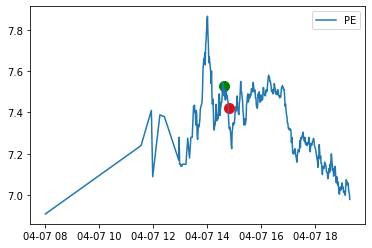

current_value=4.34 series = [4.28   4.1899 4.2297 4.3121 4.33   4.4    4.39   4.4    4.435  4.48
 4.54   4.54   4.625  4.58   4.4999 4.545  4.54   4.5479 4.615  4.63
 4.61   4.63   4.63   4.68   4.685  4.6    4.59   4.64   4.6    4.53
 4.5201 4.53   4.53   4.4002 4.33   4.38   4.31   4.3074 4.38   4.39  ]
[4.38, 4.4, 4.53, 4.53, 4.54, 4.545, 4.625, 4.63, 4.63, 4.64, 4.685]
{1: [4.38, 4.4], 2: [4.53, 4.53, 4.54, 4.545], 3: [4.625, 4.63, 4.63, 4.64, 4.685]}
resistances=[4.39, 4.54, 4.64]
current_value=4.34 series = [4.28   4.1899 4.2297 4.3121 4.33   4.4    4.39   4.4    4.435  4.48
 4.54   4.54   4.625  4.58   4.4999 4.545  4.54   4.5479 4.615  4.63
 4.61   4.63   4.63   4.68   4.685  4.6    4.59   4.64   4.6    4.53
 4.5201 4.53   4.53   4.4002 4.33   4.38   4.31   4.3074 4.38   4.39  ]
[]
{}
supports=[]
NRZ analysis for run 195 with profit -36.3


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1050.28,-1050.28,buy,2020-04-07 14:35:04.354290,4.34,[],"[4.39, 4.54, 4.64]",242,"{'rsi': 63.095687009738135, 'macd': [0.006025572053234285, 0.00938734124574303, 0.012544427180093187, 0.0199963386422759, 0.02703477253837594], 'sell_macd': [-0.0007626917670178202, 0.0017310136727548553, 0.004062069682023051, 0.009160787745321919, 0.013944713668083253], 'slow macd': [0.07971861658205004, 0.07868201102566097, 0.07772880933459536, 0.07775430620445611, 0.07793969247903831], 'macd_signal': [0.017285115836634578, 0.01570556091845627, 0.015073334170783654, 0.016057935065082102, 0.01825330255974087], 'sell_macd_signal': [0.005267717313063235, 0.004560376585001559, 0.004460715204405857, 0.005400729712589069, 0.007109526503687906]}",5.11,4.11
1,-36.30,1013.98,sell,2020-04-07 14:49:20.636723,4.19,None,None,242,"{'rsi': 39.408693095572204, 'reasons': 'below cost & macd negative', 'movement': -0.034587155963302814, 'sell_macd': [0.00720354058438577, 0.00652052812161763, 0.004864667395803934, 0.00013458543548328095, -0.003334758760032308], 'sell_macd_signal': [0.011527149918712069, 0.01052582555929318, 0.00939359392659533, 0.007541792228372921, 0.005366482030691875]}",5.11,4.11


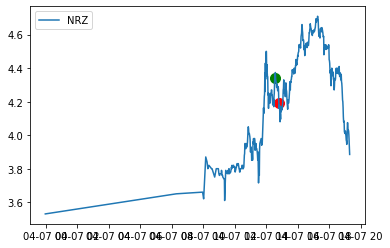

current_value=12.37 series = [12.26   12.34   12.35   12.315  12.34   12.315  12.37   12.36   12.375
 12.4    12.47   12.5    12.46   12.48   12.41   12.38   12.41   12.405
 12.415  12.44   12.39   12.39   12.22   12.22   12.19   12.12   12.07
 12.06   12.09   12.13   12.0832 12.12   12.08   12.08   12.1    12.03
 12.07   12.01   11.97   12.02   11.97   11.985  11.945 ]
[12.39, 12.41, 12.44, 12.48, 12.5]
{1: [12.39, 12.41, 12.44, 12.48, 12.5]}
resistances=[12.44]
current_value=12.37 series = [12.26   12.34   12.35   12.315  12.34   12.315  12.37   12.36   12.375
 12.4    12.47   12.5    12.46   12.48   12.41   12.38   12.41   12.405
 12.415  12.44   12.39   12.39   12.22   12.22   12.19   12.12   12.07
 12.06   12.09   12.13   12.0832 12.12   12.08   12.08   12.1    12.03
 12.07   12.01   11.97   12.02   11.97   11.985  11.945 ]
[11.985, 12.02, 12.07, 12.1, 12.12, 12.13, 12.22, 12.34, 12.35, 12.37]
{1: [11.985, 12.02, 12.07, 12.1, 12.12, 12.13, 12.22, 12.34, 12.35, 12.37]}
supports=[12

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1125.67,-1125.67,buy,2020-04-07 14:43:27.751690,12.37,[12.17],[12.44],91,"{'rsi': 60.82586086531061, 'macd': [0.04519008401992153, 0.05677641136144551, 0.06361155202660917, 0.07262926563006822, 0.07767016072531341], 'sell_macd': [0.029054998990668324, 0.03652732648725987, 0.04083657743931468, 0.046521233019625186, 0.049567442133898965], 'slow macd': [0.046747154805149904, 0.04934141278058668, 0.05132942635529858, 0.053956016331305534, 0.056046363980032154], 'macd_signal': [-0.007239015223921015, 0.005564070093152289, 0.017173566479843666, 0.028264706309888577, 0.03814579719297355], 'sell_macd_signal': [-0.006296330696102434, 0.0022684007405700275, 0.00998203608031896, 0.017289875468180206, 0.023745388801323958]}",14.35,11.71
1,-25.48,1100.19,sell,2020-04-07 15:02:28.075495,12.09,None,None,91,"{'rsi': 46.74732560664448, 'reasons': 'below cost & macd negative', 'movement': -0.018189167340339502, 'sell_macd': [0.005989698484761163, 0.002785349778916313, 0.004667865725286546, 0.0026975162584914614, -0.0009507757449647158], 'sell_macd_signal': [0.01198799358523279, 0.010147464823969495, 0.009051545004232905, 0.007780739255084617, 0.00603443625507475]}",14.35,11.71


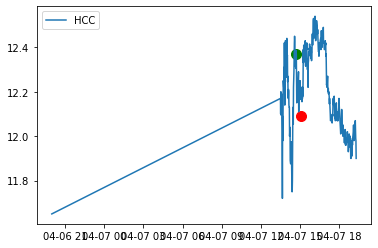

current_value=7.0 series = [6.945 6.924 6.89  6.78  6.76  6.81  6.82  6.88  6.88  6.85  6.8   6.81
 6.83  6.82  6.87  6.875 6.855 6.87  6.84  6.83  6.855 6.845 6.81  6.81
 6.805 6.735 6.7   6.665 6.685 6.705 6.73  6.69  6.68  6.665 6.66  6.54
 6.496 6.53  6.495 6.475]
[]
{}
resistances=[]
current_value=7.0 series = [6.945 6.924 6.89  6.78  6.76  6.81  6.82  6.88  6.88  6.85  6.8   6.81
 6.83  6.82  6.87  6.875 6.855 6.87  6.84  6.83  6.855 6.845 6.81  6.81
 6.805 6.735 6.7   6.665 6.685 6.705 6.73  6.69  6.68  6.665 6.66  6.54
 6.496 6.53  6.495 6.475]
[6.53, 6.73, 6.81, 6.83, 6.855, 6.87, 6.875, 6.88, 6.88]
{1: [6.53], 2: [6.73], 3: [6.81, 6.83, 6.855, 6.87, 6.875, 6.88, 6.88]}
supports=[6.86]
SKT analysis for run 195 with profit -17.16


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1001.00,-1001.00,buy,2020-04-07 14:25:16.127186,7.00,[6.86],[],143,"{'rsi': 63.19169903421438, 'macd': [-0.0051826188273143, -0.00574094822441662, 0.0014653857034883089, 0.007094674271464818, 0.027378650508238955], 'sell_macd': [-0.01462120947883605, -0.014150674149262521, -0.008665183319084946, -0.004278240031686309, 0.009585329283582134], 'slow macd': [0.17652681450799612, 0.17201628387744972, 0.16911072765338098, 0.1661670540099589, 0.16639173962789133], 'macd_signal': [0.024565467412774232, 0.01850418428533606, 0.01509642456896651, 0.013496074509466171, 0.016272589709220728], 'sell_macd_signal': [0.0014638330807452927, -0.0016590683652562702, -0.0030602913560220054, -0.003303881091154866, -0.0007260390162074659]}",8.34,6.66
1,-17.16,983.84,sell,2020-04-07 14:44:02.253518,6.88,None,None,143,"{'rsi': 44.34619931375533, 'reasons': 'below cost & macd negative', 'movement': -0.02683615819209045, 'sell_macd': [0.01752284917045177, 0.011006762330759479, 0.006305827620209925, 0.004638789824713996, -0.00087628884482438], 'sell_macd_signal': [0.03345845076094073, 0.02896811307490448, 0.02443565598396557, 0.020476282752115254, 0.01620576843272733]}",8.34,6.66


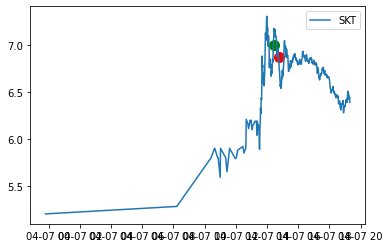

current_value=14.0 series = [13.86   13.75   13.78   13.78   13.81   13.8    13.74   13.71   13.765
 13.785  13.73   13.68   13.78   13.76   13.75   13.75   13.7    13.74
 13.8    13.79   13.79   13.805  13.8    13.7515 13.81   13.77   13.805
 13.825  13.81   13.775  13.73   13.715  13.73   13.6914 13.64   13.69
 13.51   13.51   13.58   13.53   13.52  ]
[]
{}
resistances=[]
current_value=14.0 series = [13.86   13.75   13.78   13.78   13.81   13.8    13.74   13.71   13.765
 13.785  13.73   13.68   13.78   13.76   13.75   13.75   13.7    13.74
 13.8    13.79   13.79   13.805  13.8    13.7515 13.81   13.77   13.805
 13.825  13.81   13.775  13.73   13.715  13.73   13.6914 13.64   13.69
 13.51   13.51   13.58   13.53   13.52  ]
[13.58, 13.69, 13.73, 13.75, 13.78, 13.78, 13.785, 13.8, 13.805, 13.81, 13.81, 13.825]
{1: [13.58, 13.69, 13.73, 13.75, 13.78, 13.78, 13.785, 13.8, 13.805, 13.81, 13.81, 13.825]}
supports=[13.76]
CNQ analysis for run 195 with profit -14.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2912.00,-2912.00,buy,2020-04-07 14:37:17.346786,14.00,[13.76],[],208,"{'rsi': 57.070928905681875, 'macd': [-0.03314771525756477, -0.02301142498654052, -0.013611067366946727, -0.0025012593474134093, 0.006231510574984611], 'sell_macd': [-0.022402297755231615, -0.015527033604881169, -0.00918881435000074, -0.0017929446143796213, 0.003993355759019934], 'slow macd': [0.04264247829650181, 0.042341839253127844, 0.0422374259001419, 0.042793521530361645, 0.043236705040563095], 'macd_signal': [-0.030292888033755322, -0.028836595424312363, -0.025791489812839234, -0.02113344371975407, -0.015660452860806334], 'sell_macd_signal': [-0.021945361018281522, -0.020661695535601453, -0.01836711929848131, -0.015052284361660973, -0.011243156337524792]}",14.94,13.78
1,-14.56,2897.44,sell,2020-04-07 14:42:01.102367,13.93,None,None,208,"{'rsi': 46.56493845032363, 'reasons': 'below cost & macd negative', 'movement': -0.009680170575693002, 'sell_macd': [0.005852896884277925, 0.004628475723645664, 0.004133751757908755, 0.002136125917623133, -0.00028976598282959287], 'sell_macd_signal': [-0.007823945693164249, -0.005333461409802266, -0.003440018776260062, -0.0023247898374834227, -0.0019177850665526568]}",14.94,13.78


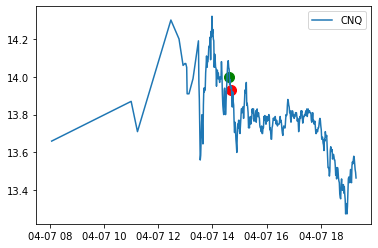

current_value=8.73 series = [7.48   7.4808 7.41   7.5    7.473  7.47   7.51   7.59      nan 7.61
 7.59   7.604  7.565  7.588  7.61   7.55   7.59   7.55   7.55   7.515
 7.49   7.515  7.5       nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan 7.5       nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan   

<ipython-input-16-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-16-b766c4f9b621>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-16-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-16-b766c4f9b621>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-593.64,-593.64,buy,2020-04-07 14:06:35.896683,8.73,"[7.56, 8.01]",[],68,"{'rsi': 64.4307593816019, 'macd': [0.14413061020843365, 0.16770236507837133, 0.19134288681318345, 0.20857756467592203, 0.21731040272022106], 'sell_macd': [0.08470490056895663, 0.09989875979410634, 0.11505373114105133, 0.12595041360437165, 0.13124717378872042], 'slow macd': [0.14207796528878447, 0.1484608628140709, 0.15551612221208355, 0.1619375885799279, 0.1671067384232261], 'macd_signal': [0.13072294667599854, 0.1381188303564731, 0.14876364164781516, 0.16072642625343653, 0.17204322154679344], 'sell_macd_signal': [0.07666627253131078, 0.0813127699838699, 0.08806096221530618, 0.09563885249311928, 0.1027605167522395]}",11.4,7.84
1,-44.20,549.44,sell,2020-04-07 14:20:25.527005,8.08,None,None,68,"{'rsi': 42.69819826602916, 'reasons': 'below cost & macd negative', 'movement': -0.07673539518900345, 'sell_macd': [0.10585817398155051, 0.08281665583772657, 0.04976071110438696, 0.017122822856272535, -0.001253750101430029], 'sell_macd_signal': [0.1119394136844836, 0.10611486211513219, 0.09484403191298314, 0.07929979010164102, 0.06318908206102682]}",11.4,7.84


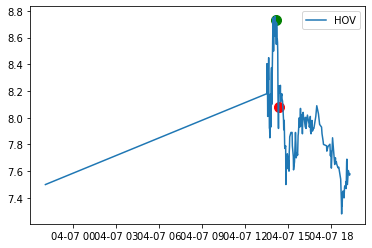

current_value=10.3 series = [10.1816 10.01   10.06   10.1    10.115  10.17   10.2    10.16   10.07
 10.055  10.07   10.07   10.15   10.13   10.1    10.13   10.1    10.14
 10.175  10.14   10.14   10.16   10.155  10.12   10.115  10.095  10.07
 10.075  10.05    9.99   10.01    9.97    9.99    9.9     9.82    9.88
  9.81    9.82    9.89    9.9     9.91  ]
[]
{}
resistances=[]
current_value=10.3 series = [10.1816 10.01   10.06   10.1    10.115  10.17   10.2    10.16   10.07
 10.055  10.07   10.07   10.15   10.13   10.1    10.13   10.1    10.14
 10.175  10.14   10.14   10.16   10.155  10.12   10.115  10.095  10.07
 10.075  10.05    9.99   10.01    9.97    9.99    9.9     9.82    9.88
  9.81    9.82    9.89    9.9     9.91  ]
[9.88, 9.99, 10.01, 10.07, 10.075, 10.13, 10.15, 10.16, 10.175, 10.2]
{1: [9.88], 2: [9.99, 10.01, 10.07, 10.075, 10.13, 10.15, 10.16, 10.175, 10.2]}
supports=[10.11]
BRX analysis for run 195 with profit -38.13


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1266.90,-1266.90,buy,2020-04-07 14:35:41.601116,10.30,[10.11],[],123,"{'rsi': 66.78575341888885, 'macd': [-0.004453835685216845, 0.01029688321254163, 0.028118137241127883, 0.04255794438898164, 0.05498163438357828], 'sell_macd': [-0.0065557724368883186, 0.0034295275175644235, 0.01532158556626051, 0.024908623194253465, 0.033094514551207155], 'slow macd': [0.1134793849845046, 0.11329726998567402, 0.11422800341540018, 0.11506155223912629, 0.1159642909973968], 'macd_signal': [-0.017522483863400055, -0.011958610448211717, -0.003943260910343797, 0.00535698014952129, 0.01528191099633269], 'sell_macd_signal': [-0.017547405056978976, -0.013352018542070295, -0.007617297720404134, -0.0011121135374726138, 0.00572921208026334]}",11.77,9.81
1,-38.13,1228.77,sell,2020-04-07 14:48:31.646691,9.99,None,None,123,"{'rsi': 41.982350781515535, 'reasons': 'below cost & macd negative', 'movement': -0.025242718446602093, 'sell_macd': [0.02432437679229338, 0.019485928272436226, 0.013384722565113805, 0.005859306136484221, -0.000600230121362344], 'sell_macd_signal': [0.030337198499234636, 0.028166944453874954, 0.025210500076122723, 0.021340261288195023, 0.01695216300628355]}",11.77,9.81


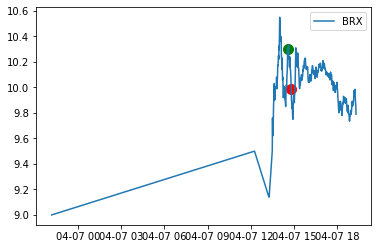

current_value=17.85 series = [17.18   16.81   16.75   16.7    16.76   16.54   16.37   16.38   16.465
 16.51   16.54   16.6    16.55   16.54   16.67   16.615  16.9    16.79
 16.7328 16.67   16.67   16.82   16.8    16.815  16.73   16.75   16.76
 16.8    16.8502 16.83   16.77   16.8198 16.83   16.785  16.71   16.68
 16.59   16.68   16.67   16.66   16.58   16.48   16.35   16.1    15.82
 15.78  ]
[]
{}
resistances=[]
current_value=17.85 series = [17.18   16.81   16.75   16.7    16.76   16.54   16.37   16.38   16.465
 16.51   16.54   16.6    16.55   16.54   16.67   16.615  16.9    16.79
 16.7328 16.67   16.67   16.82   16.8    16.815  16.73   16.75   16.76
 16.8    16.8502 16.83   16.77   16.8198 16.83   16.785  16.71   16.68
 16.59   16.68   16.67   16.66   16.58   16.48   16.35   16.1    15.82
 15.78  ]
[16.6, 16.67, 16.68, 16.76, 16.815, 16.82, 16.83, 16.8502, 16.9]
{1: [16.6, 16.67, 16.68, 16.76, 16.815, 16.82, 16.83, 16.8502, 16.9]}
supports=[16.77]
USCR analysis for run 195 with profit

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-535.5,-535.5,buy,2020-04-07 14:05:55.340855,17.85,[16.77],[],30,"{'rsi': 59.180154722645696, 'macd': [0.23577798126581584, 0.2225317227556438, 0.2213441216692651, 0.24100917356262386, 0.2496970726407497], 'sell_macd': [0.14096059302190866, 0.1318276840409034, 0.130635447379845, 0.1430644130026586, 0.1483043289035173], 'slow macd': [0.17256132444124717, 0.1742014689317486, 0.17778290299688493, 0.18542854400924114, 0.19136972985225853], 'macd_signal': [0.23606362395060104, 0.2333572437116096, 0.2309546193031407, 0.23296553015503735, 0.2363118386521798], 'sell_macd_signal': [0.14375973671114306, 0.14137332617709514, 0.13922575041764512, 0.1399934829346478, 0.1416556521284217]}",23.85,15.85
1,-28.8,506.7,sell,2020-04-07 14:20:21.737639,16.89,None,None,30,"{'rsi': 41.08080048055508, 'reasons': 'below cost & macd negative', 'movement': -0.05518207282913182, 'sell_macd': [0.05237711261000655, 0.03246898045673774, 0.011599410201505123, -0.01572232519479755, -0.03706754335821927], 'sell_macd_signal': [0.08981400449940982, 0.07834499969087541, 0.06499588179300135, 0.048852240395441573, 0.0316682836447094]}",23.85,15.85


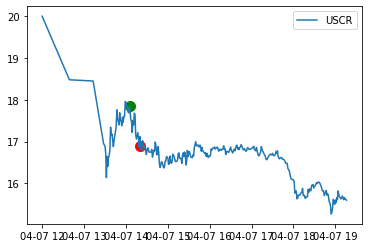

current_value=8.93 series = [8.995  8.8536 8.84   8.95   8.96   9.01   9.01   8.99   8.96   8.99
 9.02   9.013  9.05   9.08   9.05   9.1    9.08   9.135  9.14   9.095
 9.07   9.05   9.06   9.045  9.05   9.02   9.01   9.046  9.04   9.02
 8.98   8.9    8.92   8.81   8.705  8.74   8.67   8.64   8.72   8.72
 8.75  ]
[9.01, 9.01, 9.02, 9.046, 9.05, 9.06, 9.08, 9.1, 9.14]
{1: [9.01, 9.01, 9.02, 9.046, 9.05, 9.06, 9.08, 9.1, 9.14]}
resistances=[9.06]
current_value=8.93 series = [8.995  8.8536 8.84   8.95   8.96   9.01   9.01   8.99   8.96   8.99
 9.02   9.013  9.05   9.08   9.05   9.1    9.08   9.135  9.14   9.095
 9.07   9.05   9.06   9.045  9.05   9.02   9.01   9.046  9.04   9.02
 8.98   8.9    8.92   8.81   8.705  8.74   8.67   8.64   8.72   8.72
 8.75  ]
[8.72, 8.74, 8.92]
{1: [8.72, 8.74], 2: [8.92]}
supports=[8.73]
PDCE analysis for run 195 with profit -48.75


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1741.35,-1741.35,buy,2020-04-07 14:35:52.103880,8.93,[8.73],[9.06],195,"{'rsi': 59.434087388113674, 'macd': [0.008784840175833253, 0.015160778718746215, 0.021578841352440037, 0.028060470579948316, 0.03431063056640227], 'sell_macd': [0.0017022733231932818, 0.0061181125920501955, 0.010518531339315018, 0.014917318267842816, 0.01912264161126842], 'slow macd': [0.07965407583800577, 0.07926247340606274, 0.07909528944383659, 0.07915563672298198, 0.0793836401385839], 'macd_signal': [0.011324607376320546, 0.01209184164480568, 0.013989241586332551, 0.016803487385055705, 0.020304916021325017], 'sell_macd_signal': [0.002003051021258309, 0.0028260633354166864, 0.004364556936196353, 0.006475109202525646, 0.0090046156842742]}",9.88,8.64
1,-48.75,1692.60,sell,2020-04-07 14:49:27.904050,8.68,None,None,195,"{'rsi': 38.31429200201103, 'reasons': 'below cost & macd negative', 'movement': -0.02793296089385475, 'sell_macd': [0.011472608037630394, 0.00967045941312783, 0.00710163633672245, -0.0022650002986157602, -0.010053743127468096], 'sell_macd_signal': [0.01683120951832127, 0.015399059497282583, 0.013739574865170556, 0.010538659832413292, 0.006420179240437015]}",9.88,8.64


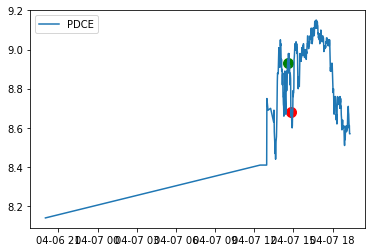

current_value=13.91 series = [13.885  13.81   13.89   13.875  13.89   13.945  14.01   13.97   13.925
 13.97   14.03   14.05   14.085  14.18   14.12   14.15   14.155  14.21
 14.255  14.3    14.31   14.24   14.13   14.08   14.015  13.955  13.895
 13.95   13.98   13.93   13.8699 13.83   13.88   13.82   13.74   13.78
 13.68   13.625  13.685  13.7   ]
[13.98, 14.01, 14.18, 14.31]
{1: [13.98, 14.01], 2: [14.18, 14.31]}
resistances=[14.0, 14.24]
current_value=13.91 series = [13.885  13.81   13.89   13.875  13.89   13.945  14.01   13.97   13.925
 13.97   14.03   14.05   14.085  14.18   14.12   14.15   14.155  14.21
 14.255  14.3    14.31   14.24   14.13   14.08   14.015  13.955  13.895
 13.95   13.98   13.93   13.8699 13.83   13.88   13.82   13.74   13.78
 13.68   13.625  13.685  13.7   ]
[13.78, 13.88, 13.89]
{1: [13.78, 13.88, 13.89]}
supports=[13.85]
BLDR analysis for run 195 with profit -26.41


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1933.49,-1933.49,buy,2020-04-07 14:34:44.334810,13.91,[13.85],"[14.0, 14.24]",139,"{'rsi': 59.037558289339806, 'macd': [0.003591642355493363, 0.008354488989832376, 0.018372622518278092, 0.026809933715568945, 0.035109138400448714], 'sell_macd': [-0.0003190436512614525, 0.0030441511159011725, 0.009781132088809485, 0.015423180482128984, 0.020917982081053665], 'slow macd': [0.09791626083591964, 0.09637714036127143, 0.09608644672927902, 0.09582525847092782, 0.09583153787262866], 'macd_signal': [-0.01337919342035963, -0.009032456938321227, -0.0035514410470013635, 0.0025208339055126988, 0.009038494804499902], 'sell_macd_signal': [-0.013384833750592472, -0.010099036777293744, -0.006123003004073098, -0.0018137663068326813, 0.002732583370744588]}",15.25,13.51
1,-26.41,1907.08,sell,2020-04-07 14:47:17.771001,13.72,None,None,139,"{'rsi': 44.49228462304445, 'reasons': 'below cost & macd negative', 'movement': -0.014342058085335322, 'sell_macd': [0.010409944037892416, 0.004663734851789059, 0.0009048220463601098, -0.002035951854576723, -0.005080243831221409], 'sell_macd_signal': [0.012923659158530262, 0.011271674297182021, 0.009198303847017638, 0.006951452706698766, 0.004545113399114731]}",15.25,13.51


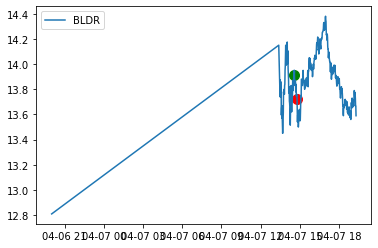

current_value=15.14 series = [14.77  14.69  14.51  14.5   14.61  14.6   14.66  14.72  14.75  14.69
 14.71  14.73  14.73  14.775 14.73  14.67  14.68  14.62  14.6   14.62
 14.61  14.615 14.67  14.65  14.61  14.56  14.54  14.56  14.66  14.74
 14.7   14.71  14.63  14.65  14.64  14.45  14.48  14.4   14.38  14.54
 14.53  14.61 ]
[]
{}
resistances=[]
current_value=15.14 series = [14.77  14.69  14.51  14.5   14.61  14.6   14.66  14.72  14.75  14.69
 14.71  14.73  14.73  14.775 14.73  14.67  14.68  14.62  14.6   14.62
 14.61  14.615 14.67  14.65  14.61  14.56  14.54  14.56  14.66  14.74
 14.7   14.71  14.63  14.65  14.64  14.45  14.48  14.4   14.38  14.54
 14.53  14.61 ]
[14.48, 14.54, 14.61, 14.62, 14.65, 14.67, 14.68, 14.71, 14.73, 14.74, 14.75, 14.775]
{1: [14.48, 14.54, 14.61, 14.62, 14.65, 14.67, 14.68, 14.71, 14.73, 14.74, 14.75, 14.775]}
supports=[14.66]
WRI analysis for run 195 with profit -55.12


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1574.56,-1574.56,buy,2020-04-07 14:38:11.272129,15.14,[14.66],[],104,"{'rsi': 63.9067269501377, 'macd': [0.033034427622489204, 0.051278111645419955, 0.06817811352497571, 0.0842316407693584, 0.09146182147912363], 'sell_macd': [0.018460928946732125, 0.030494176363358605, 0.04155262660536074, 0.05196761865620303, 0.05655114988210208], 'slow macd': [0.09867525942443933, 0.10090935307820281, 0.10344314439567448, 0.10632858271791257, 0.10793357242147117], 'macd_signal': [0.002270704846392529, 0.012072186206198014, 0.023293371669953555, 0.035481025489834526, 0.046677184687692344], 'sell_macd_signal': [-0.0034471039862981777, 0.0033411520836331785, 0.010983446987978693, 0.01918028132162356, 0.026654455033719264]}",16.88,14.56
1,-55.12,1519.44,sell,2020-04-07 14:49:22.906437,14.61,None,None,104,"{'rsi': 37.88513438751809, 'reasons': 'below cost & macd negative', 'movement': -0.029062087186261642, 'sell_macd': [0.03317283560065576, 0.025089396906642136, 0.01664659536706381, 0.00024120981197661706, -0.012025859579155807], 'sell_macd_signal': [0.03913615650505792, 0.03632680458537476, 0.03239076274171257, 0.02596085215576538, 0.018363509808781143]}",16.88,14.56


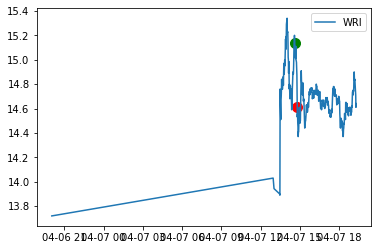

current_value=4.29 series = [4.38   4.5    4.42   4.43   4.47   4.46   4.64   4.535  4.495  4.48
 4.41   4.42   4.41   4.41   4.39   4.375  4.38   4.36   4.38   4.35
 4.36   4.33   4.33   4.3    4.31   4.28   4.25   4.24   4.25   4.2
 4.19   4.19   4.17   4.14   4.13   4.105  4.12   4.11   4.0799 4.12
 4.14  ]
[4.31, 4.33, 4.36, 4.38, 4.38, 4.41, 4.42, 4.47, 4.5, 4.64]
{1: [4.31, 4.33, 4.36, 4.38, 4.38, 4.41, 4.42], 2: [4.47, 4.5], 3: [4.64]}
resistances=[4.37, 4.48]
current_value=4.29 series = [4.38   4.5    4.42   4.43   4.47   4.46   4.64   4.535  4.495  4.48
 4.41   4.42   4.41   4.41   4.39   4.375  4.38   4.36   4.38   4.35
 4.36   4.33   4.33   4.3    4.31   4.28   4.25   4.24   4.25   4.2
 4.19   4.19   4.17   4.14   4.13   4.105  4.12   4.11   4.0799 4.12
 4.14  ]
[4.12, 4.19, 4.25]
{1: [4.12], 2: [4.19], 3: [4.25]}
supports=[]
CONN analysis for run 195 with profit -27.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-909.48,-909.48,buy,2020-04-07 14:34:38.215791,4.29,[],"[4.37, 4.48]",212,"{'rsi': 61.06326679749894, 'macd': [-0.017368818644813544, -0.01429051580686469, -0.0077272812095339205, -0.0024970856565307287, 0.006415427505014115], 'sell_macd': [-0.014128722514054282, -0.011774670069079285, -0.007190023098072373, -0.0035241939895200858, 0.002494948094930116], 'slow macd': [0.06093645830039307, 0.059398903580721196, 0.058688983938862904, 0.05794197033163684, 0.058121639987153806], 'macd_signal': [-0.020177534274751337, -0.01900013058117401, -0.01674556070684599, -0.013895865696782939, -0.009833607056423528], 'sell_macd_signal': [-0.017796921604894274, -0.016592471297731275, -0.014711981657799494, -0.012474424124143613, -0.009480549680328867]}",5.15,4.0
1,-27.56,881.92,sell,2020-04-07 14:51:09.513209,4.16,None,None,212,"{'rsi': 40.169526039406996, 'reasons': 'below cost & macd negative', 'movement': -0.03496503496503505, 'sell_macd': [0.018251443871943884, 0.015845182430646254, 0.011686469847418834, 0.00569673965467743, -0.000603007763753105], 'sell_macd_signal': [0.014592129882668683, 0.014842740392264197, 0.014211486283295124, 0.012508536957571585, 0.009886228013306648]}",5.15,4.0


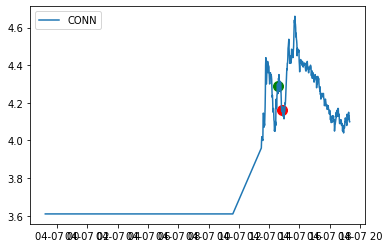

current_value=6.3 series = [6.22   6.1907 6.165  6.16   6.18   6.27   6.24   6.15   6.03   6.03
 6.0672 6.18   6.1649 6.175  6.09   6.0803 6.16   6.163  6.2201 6.22
 6.22   6.23   6.24   6.28   6.29   6.32   6.2902 6.28   6.26   6.28
 6.28   6.365  6.3462 6.34   6.345  6.3814 6.35   6.32   6.25   6.2575
 6.27   6.2701 6.23   6.23   6.2439 6.2307 6.18   6.13   6.16   6.125
 6.105  6.15   6.16   6.14  ]
[6.32, 6.365, 6.3814]
{1: [6.32, 6.365, 6.3814]}
resistances=[6.36]
current_value=6.3 series = [6.22   6.1907 6.165  6.16   6.18   6.27   6.24   6.15   6.03   6.03
 6.0672 6.18   6.1649 6.175  6.09   6.0803 6.16   6.163  6.2201 6.22
 6.22   6.23   6.24   6.28   6.29   6.32   6.2902 6.28   6.26   6.28
 6.28   6.365  6.3462 6.34   6.345  6.3814 6.35   6.32   6.25   6.2575
 6.27   6.2701 6.23   6.23   6.2439 6.2307 6.18   6.13   6.16   6.125
 6.105  6.15   6.16   6.14  ]
[6.16, 6.16, 6.175, 6.18, 6.2201, 6.2439, 6.27, 6.2701, 6.28]
{1: [6.16, 6.16, 6.175, 6.18, 6.2201, 6.2439, 6.27, 6.2701, 

,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1902.6,-1902.6,buy,2020-04-07 14:37:03.248247,6.3,[6.22],[6.36],302,"{'rsi': 65.6063965527835, 'macd': [-0.007080781720387286, -0.0062707866913873644, -0.0007783884585084166, 0.005926805467063367, 0.013505782981775738], 'sell_macd': [-0.007620354217648284, -0.006825501551797508, -0.0030006098439692153, 0.0015772357704948448, 0.00668234617435548], 'slow macd': [0.06159084073141052, 0.059957525200514006, 0.059318545137580614, 0.05911559939373401, 0.059314143754323645], 'macd_signal': [-0.00024345314034288968, -0.0014489198505517847, -0.001314813572143111, 0.0001335102356981848, 0.0028079647849136957], 'sell_macd_signal': [-0.004374860365689218, -0.004864988602910876, -0.004492112851122544, -0.003278243126799066, -0.0012861252665681568]}",6.91,6.11
1,-60.4,1842.2,sell,2020-04-07 14:50:16.478543,6.1,None,None,302,"{'rsi': 31.71102140041397, 'reasons': 'below cost & macd negative', 'movement': -0.030110935023771712, 'sell_macd': [0.003765010312219985, 0.0020457694627697975, -0.001912674958396643, -0.006541168339065706, -0.010582316839080619], 'sell_macd_signal': [0.006034239681916534, 0.005236545638087187, 0.003806701518790421, 0.001737127547219195, -0.000726761330040768]}",6.91,6.11


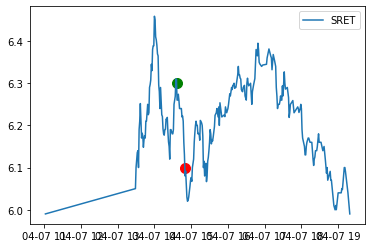

current_value=9.99 series = [9.73   9.705  9.56   9.55   9.56   9.58   9.615  9.585  9.56   9.48
 9.48   9.49   9.49   9.58   9.525  9.5    9.533  9.49   9.52   9.58
 9.55   9.57   9.65   9.655  9.65   9.6401 9.62   9.62   9.65   9.7
 9.66   9.66   9.635  9.65   9.55   9.45   9.475  9.4    9.41   9.43
 9.42  ]
[]
{}
resistances=[]
current_value=9.99 series = [9.73   9.705  9.56   9.55   9.56   9.58   9.615  9.585  9.56   9.48
 9.48   9.49   9.49   9.58   9.525  9.5    9.533  9.49   9.52   9.58
 9.55   9.57   9.65   9.655  9.65   9.6401 9.62   9.62   9.65   9.7
 9.66   9.66   9.635  9.65   9.55   9.45   9.475  9.4    9.41   9.43
 9.42  ]
[9.43, 9.475, 9.49, 9.533, 9.58, 9.58, 9.615, 9.65, 9.655, 9.66, 9.7]
{1: [9.43, 9.475, 9.49, 9.533, 9.58, 9.58, 9.615, 9.65, 9.655, 9.66, 9.7]}
supports=[9.58]
KIM analysis for run 195 with profit -23.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1568.43,-1568.43,buy,2020-04-07 14:34:11.172677,9.99,[9.58],[],157,"{'rsi': 63.43199617765831, 'macd': [-0.03801655363603906, -0.023241750308743647, -0.011401186444809142, 0.000398699049096507, 0.013228823592195127], 'sell_macd': [-0.027143929797677657, -0.017069607508725326, -0.008997803030206697, -0.0010327891114876309, 0.007524790424026762], 'slow macd': [0.09533150685090774, 0.0943922716682053, 0.09337717800883816, 0.09277372370166681, 0.09278985994492572], 'macd_signal': [-0.03956193644388363, -0.03629789921685563, -0.03131855666244633, -0.024975105520137764, -0.017334319697671186], 'sell_macd_signal': [-0.030672544391377975, -0.027951957014847446, -0.024161126217919295, -0.019535458796632963, -0.014123408952501018]}",11.15,9.61
1,-23.55,1544.88,sell,2020-04-07 14:45:26.123109,9.84,None,None,157,"{'rsi': 45.39696521157898, 'reasons': 'below cost & macd negative', 'movement': -0.01600800400200084, 'sell_macd': [0.012285489450290399, 0.009715942981259218, 0.004990115304334353, 0.0012428454871944439, -0.00143350561041089], 'sell_macd_signal': [0.013572286020341665, 0.012801017412525175, 0.01123883699088701, 0.009239638690148497, 0.00710500983003662]}",11.15,9.61


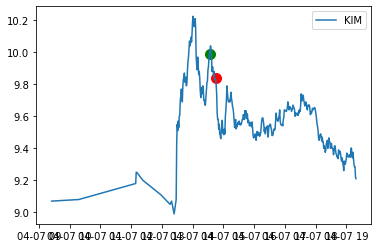

current_value=6.24 series = [6.44   6.3738 6.36   6.2    6.2    6.25   6.23   6.4    6.43   6.41
 6.305  6.31   6.34   6.35   6.36   6.31   6.3    6.4    6.3    6.29
 6.22   6.14   6.12   6.195  6.19   6.14   6.16   6.13   6.24   6.28
 6.27   6.22   6.23   6.14   6.155  6.11   5.9814 6.06   5.97   5.96
 6.025  6.01  ]
[6.25, 6.28, 6.36, 6.4, 6.43]
{1: [6.25, 6.28], 2: [6.36, 6.4, 6.43]}
resistances=[6.26, 6.4]
current_value=6.24 series = [6.44   6.3738 6.36   6.2    6.2    6.25   6.23   6.4    6.43   6.41
 6.305  6.31   6.34   6.35   6.36   6.31   6.3    6.4    6.3    6.29
 6.22   6.14   6.12   6.195  6.19   6.14   6.16   6.13   6.24   6.28
 6.27   6.22   6.23   6.14   6.155  6.11   5.9814 6.06   5.97   5.96
 6.025  6.01  ]
[6.025, 6.06, 6.155, 6.16, 6.195, 6.23]
{1: [6.025, 6.06], 2: [6.155, 6.16, 6.195, 6.23]}
supports=[6.04, 6.18]
DCP analysis for run 195 with profit -39.76


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-886.08,-886.08,buy,2020-04-07 14:33:03.910562,6.24,"[6.04, 6.18]","[6.26, 6.4]",142,"{'rsi': 62.832458495138496, 'macd': [0.026975746272501766, 0.02744059984954106, 0.02410177459110141, 0.02938785993459092, 0.04356484577425146], 'sell_macd': [0.011019315208042002, 0.011675852471769055, 0.009828013294520765, 0.013585177399333404, 0.02308965361867621], 'slow macd': [0.12262009174971666, 0.12064853920468366, 0.11796195921150421, 0.11694090027461801, 0.1178936310963401], 'macd_signal': [0.02933324347482941, 0.02895471474977174, 0.027984126718037676, 0.028264873361348326, 0.031324867843928954], 'sell_macd_signal': [0.010694886774230607, 0.010891079913738297, 0.01067846658989479, 0.011259808751782513, 0.013625777725161253]}",7.51,5.82
1,-39.76,846.32,sell,2020-04-07 14:50:20.919267,5.96,None,None,142,"{'rsi': 44.00520528390543, 'reasons': 'below cost & macd negative', 'movement': -0.043269230769230844, 'sell_macd': [0.005423010081159418, 0.006043287167943667, 0.003850733116503413, -0.0010246431978195858, -0.005329811193424128], 'sell_macd_signal': [0.012876633626995397, 0.01150996433518505, 0.009978118091448723, 0.007777565833595061, 0.005156090428191223]}",7.51,5.82


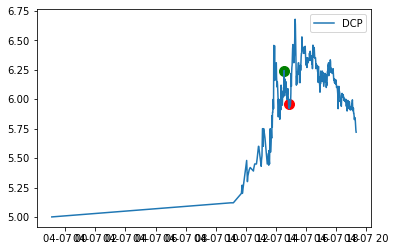

In [17]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

